In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot

from test_functions import *

set_matplotlib_style()

In [2]:
# run_path = '/home/akallits/Documents/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/ParameterTrees/Run243-Pool4_treeParam.root'
# run_path = '/local/home/dn277127/Bureau/picosec/Run243-Pool4_treeParam.root'
# run_path = '/home/dylan/Desktop/picosec/Run243-Pool4_treeParam.root'
run_path = '/data/akallits/Saclay_Analysis/data/data/2023_April_h4/processedTrees/ParameterTrees/Run243-Pool4_treeParam.root'

In [3]:
tree = get_tree(run_path, 'ParameterTree')

In [4]:
event_start, event_end = 4416, None
min_ampl, max_ampl = -2, 2  # V
min_charge, max_charge = -1, 50.0  # fC
min_charge_tot, max_charge_tot = -1, 100.0  # fC

In [5]:
channels = ['C1', 'C2', 'C4']
global_vars = ['eventNo']
channel_vars = ['hitX', 'hitY']
peak_param_channel_vars = ['ampl', 'dampl', 'charge', 'echargefit', 'echargefixed', 'totcharge', 'totchargefixed', 'tfit20','tfit20_nb', 'tnaive20', 'sigmoidR[4]' ]

branches = []
for channel in channels:
    for channel_var in channel_vars:
        branches.append(f'{channel_var}_{channel}')
    for var in peak_param_channel_vars:
        branches.append(f'peakparam_{channel}/peakparam_{channel}.{var}')
for var in global_vars:
    branches.append(var)
df = get_df_branches(tree, branches)

if event_start is not None:
    df = df[df['eventNo'] >= event_start]
if event_end is not None:
    df = df[df['eventNo'] <= event_end]

<Report start=0 stop=30400 source='/data/akallits/Saclay_Analysis/data/data/2023_April_h4/processedTrees/ParameterTrees/Run243-Pool4_treeParam.root:/ParameterTree;1'>


In [6]:
for channel in channels:
    get_single_peak(df, channel)
    # get_single_track(df, channel)
# Get MCP center using all tracks
median_x, median_y = get_center_all_tracks(df, 'C1')
get_closest_track_indices(df, 'C1', (median_x, median_y))

# print(df['closest_hit_index'])

# get_single_track(df, 'C1', np.array(df['closest_hit_index']))
# get_single_track(df, 'C1', 0)
# get_single_track(df, 'C2', 0)
# get_single_track(df, 'C4', 0)



hit_x: [76.14204406738281, 26.117359161376953], hit_y: [45.544525146484375, 29.403099060058594], distances: [2517.19689954   16.12185206], min_idx: 1
hit_x: [22.329296112060547, 24.09388542175293], hit_y: [81.5196762084961, 40.799434661865234], distances: [3004.48045765  214.46052577], min_idx: 1
hit_x: [50.86491394042969, 28.59334945678711], hit_y: [33.65180206298828, 30.87372398376465], distances: [500.35616172  14.44792127], min_idx: 1
hit_x: [73.7822494506836, 30.41176986694336], hit_y: [21.071868896484375, 27.8580265045166], distances: [2.00207313e+03 1.38552951e+00], min_idx: 1
hit_x: [41.39210891723633, 32.26426696777344, 75.01637268066406, 76.54804229736328, 38.90028762817383], hit_y: [38.18463134765625, 35.90861511230469, 20.138553619384766, 15.986964225769043, 43.873294830322266], distances: [ 263.76751702   84.22243641 2125.26292704 2342.81097307  368.14684635], min_idx: 1
hit_x: [72.01624298095703, 30.581205368041992], hit_y: [53.38151168823242, 29.17333984375], distances: 

In [7]:
for channel in channels:
    for xy in ['X', 'Y']:
        col_name = f'hit{xy}_{channel}'
        df[col_name] = df.apply(lambda row: row[col_name][int(row['closest_hit_index'])] if isinstance(row[col_name], list) and ~np.isnan(row['closest_hit_index']) else np.nan, axis=1)


In [8]:
print(df[f'peakparam_C4/peakparam_C4.sigmoidR[4]'])
sigmoidR = df[f'peakparam_C4/peakparam_C4.sigmoidR[4]'][pd.notnull(df['peakparam_C4/peakparam_C4.sigmoidR[4]'])]
print(sigmoidR)
np_sigmoidR = np.array(sigmoidR.tolist())
print(np_sigmoidR)

4416                                                   NaN
4417     [-0.08170317677650336, 204.50103734264457, 4.6...
4418     [-0.04638771289282878, 218.8787739452861, 5.30...
4419                                                   NaN
4420     [-0.08645096359214566, 227.494262115233, 5.053...
                               ...                        
30395                                                  NaN
30396    [-0.21141281487465893, 207.31575423560074, 5.2...
30397    [-0.02988950312537784, 226.35167948237319, 5.7...
30398    [-0.027903222481871777, 222.59003269493763, 6....
30399                                                  NaN
Name: peakparam_C4/peakparam_C4.sigmoidR[4], Length: 25984, dtype: object
4417     [-0.08170317677650336, 204.50103734264457, 4.6...
4418     [-0.04638771289282878, 218.8787739452861, 5.30...
4420     [-0.08645096359214566, 227.494262115233, 5.053...
4422     [-0.018336023770576207, 223.77458232216924, 4....
4423     [-0.08334987252547849, 209.75899

[-0.08170318 -0.04638771 -0.08645096 ... -0.21141281 -0.0298895
 -0.02790322]
[ 0.00019838  0.00029959  0.00011232 ... -0.00018458  0.00011478
 -0.00013179]


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 2.000e+00,
        2.000e+00, 4.000e+00, 7.000e+00, 8.000e+00, 1.000e+01, 7.000e+00,
        9.000e+00, 7.000e+00, 1.300e+01, 3.100e+01, 2.400e+01, 3.700e+01,
        4.000e+01, 6.700e+01, 1.020e+02, 1.030e+02, 1.630e+02, 2.600e+02,
        4.370e+02, 7.210e+02, 1.680e+03, 5.825e+03, 7.546e+03, 2.305e+03,
        8.700e+02, 4.780e+02, 3.010e+0

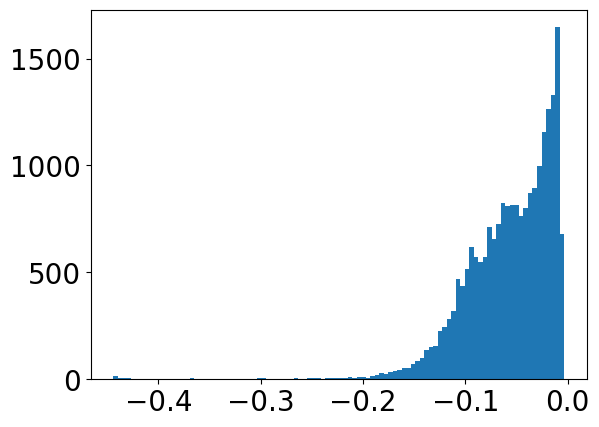

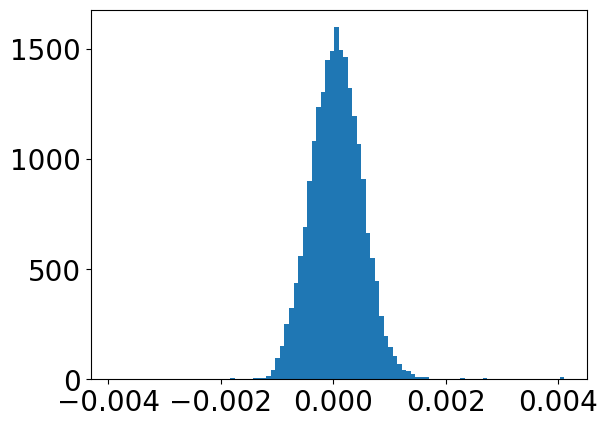

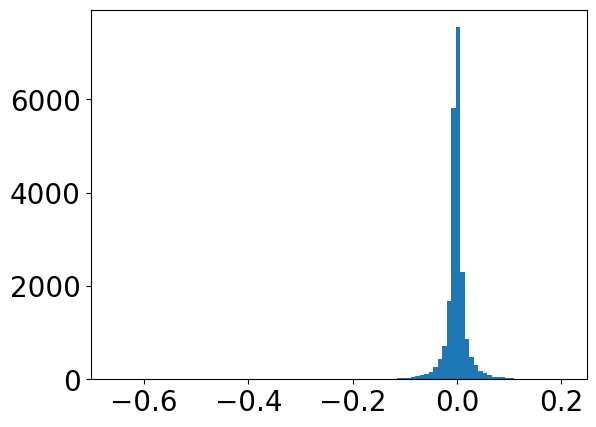

In [9]:
np_sigmoidR = np_sigmoidR[(np_sigmoidR[:, 0] > -999.) & (np_sigmoidR[:, 3] > -999.)]

amplitudes = np_sigmoidR[:, 0]
print(amplitudes)
baselines = np_sigmoidR[:, 3]
print(baselines)

division = baselines/amplitudes

fig, ax = plt.subplots()
ax.hist(amplitudes, bins=100)

fig, ax = plt.subplots()
ax.hist(baselines, bins=100)

fig,ax = plt.subplots()
ax.hist(division, bins=100)

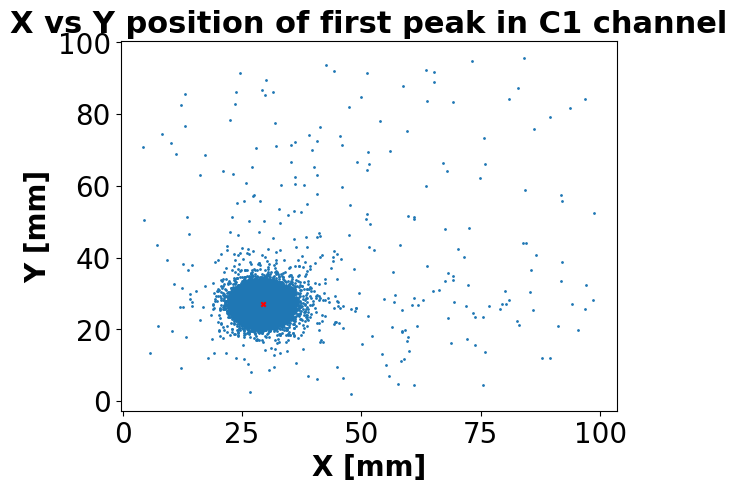

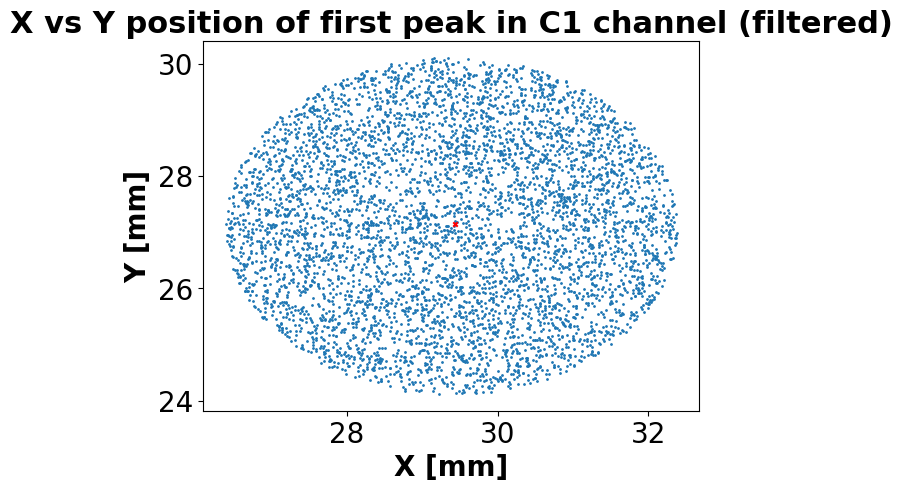

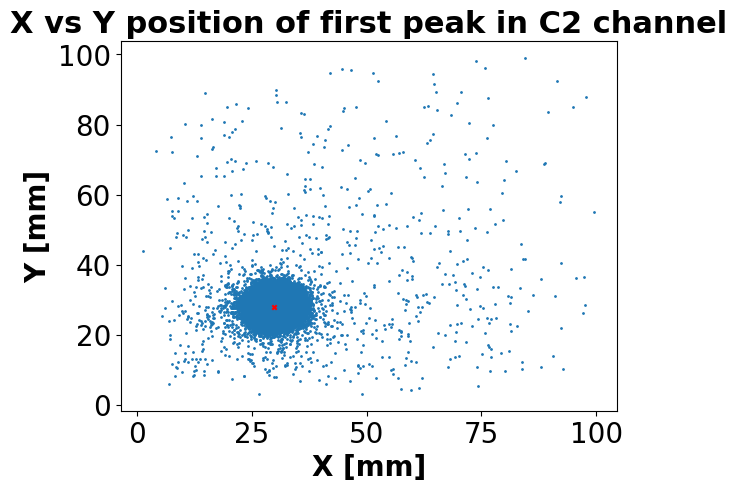

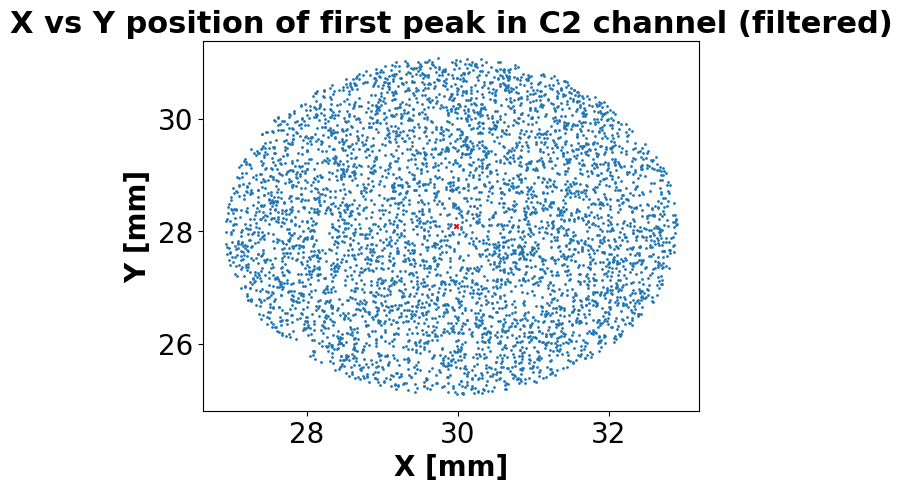

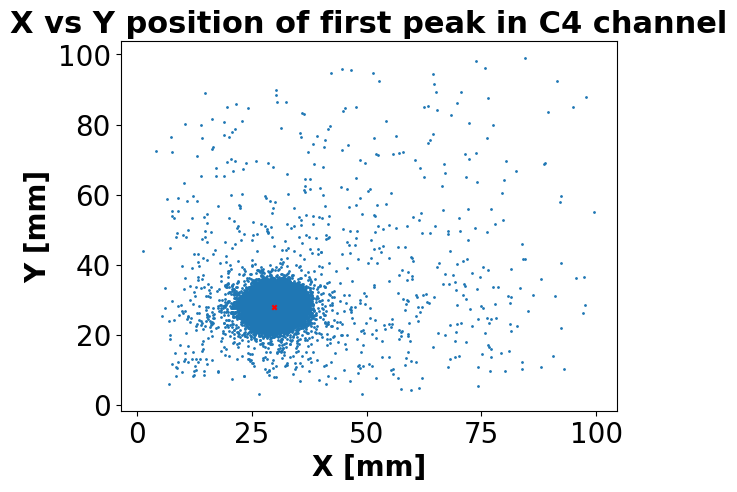

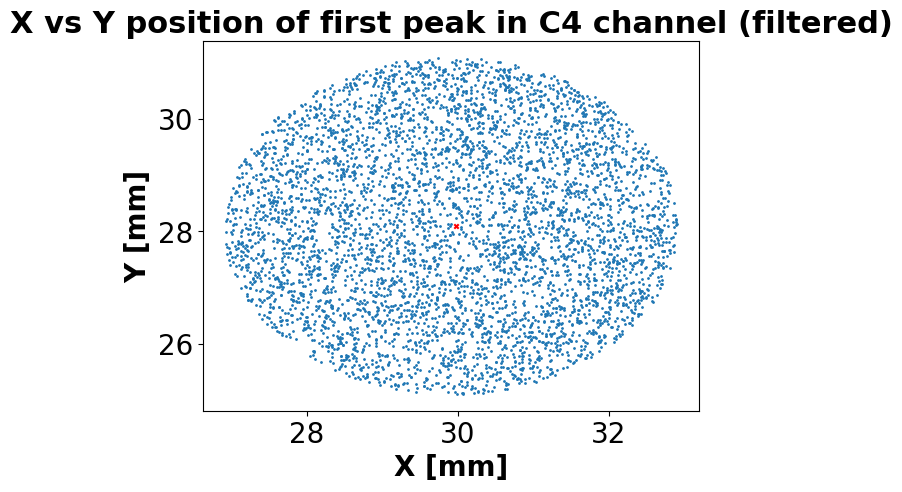

In [10]:
channels = ['C1', 'C2', 'C4']
filter_dict = {}
for channel in channels:
    first_c_xs = df[f'hitX_{channel}']
    first_c_xs = np.array(first_c_xs)
    first_c_ys = df[f'hitY_{channel}']
    first_c_ys = np.array(first_c_ys)

    xy_filter_cut = (first_c_xs > -100) & (first_c_xs < 100) & (first_c_ys > -100) & (first_c_ys < 100)

    first_c_xs_plt = first_c_xs[xy_filter_cut]
    median_x = np.median(first_c_xs_plt)

    first_c_ys_plt = first_c_ys[xy_filter_cut]
    median_y = np.median(first_c_ys_plt)

    fig, ax = plt.subplots()
    ax.scatter(first_c_xs_plt, first_c_ys_plt, s=1)
    ax.scatter(median_x, median_y, s=10, c='red', marker='x')
    ax.set_title(f'X vs Y position of first peak in {channel} channel')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')

    # Select events within 10 mm of the median
    r = np.sqrt((first_c_xs - median_x)**2 + (first_c_ys - median_y)**2)
    # filter = (1 < r) & (r < 3)
    filter = r < 3
    first_c_xs_filtered = first_c_xs[filter]
    first_c_ys_filtered = first_c_ys[filter]
    median_x = np.median(first_c_xs_filtered)
    median_y = np.median(first_c_ys_filtered)

    filter_dict.update({channel: filter})

    fig, ax = plt.subplots()
    ax.scatter(first_c_xs_filtered, first_c_ys_filtered, s=1)
    ax.scatter(median_x, median_y, s=10, c='red', marker='x')
    ax.set_title(f'X vs Y position of first peak in {channel} channel (filtered)')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')


plt.show()


C1 Number of outliers: 0 of 25984
C1 Number after filter: 25984 of 25984
C1 channel: min = 0.012497826801337581, max = 0.780148545889383
[False False False ... False False False]
C1 channel: min = 0.014984740229233559, max = 0.779766428866071
C2 Number of outliers: 4 of 25984
C2 Number after filter: 4984 of 25984
C2 channel: min = -1.0577924460996679e-22, max = 0.42080226949588656
[False False False ... False False False]
C2 channel: min = 0.002777777607591749, max = 0.3868782091897199
C4 Number of outliers: 7 of 25984
C4 Number after filter: 21774 of 25984
C4 channel: min = -0.010298717207142425, max = 0.42261918512511293
[False False False ... False False False]
C4 channel: min = 0.0013636051082937977, max = 0.4203664868569451


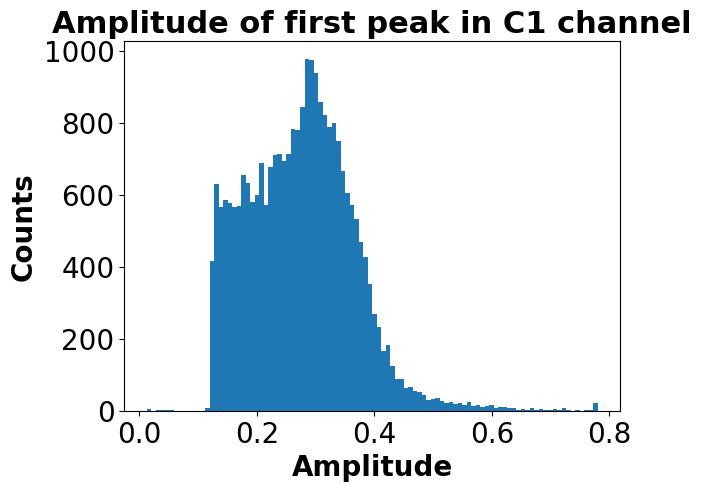

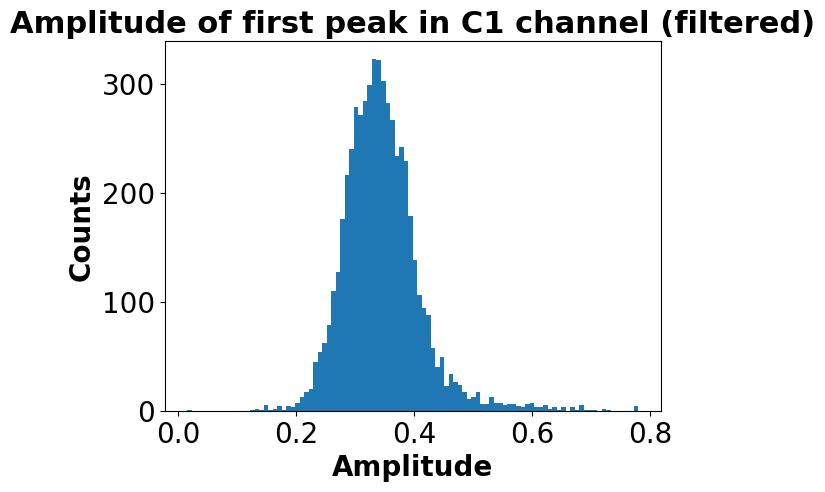

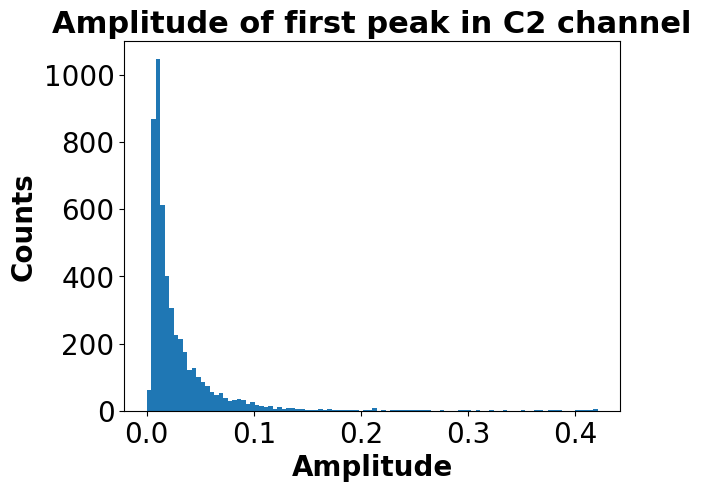

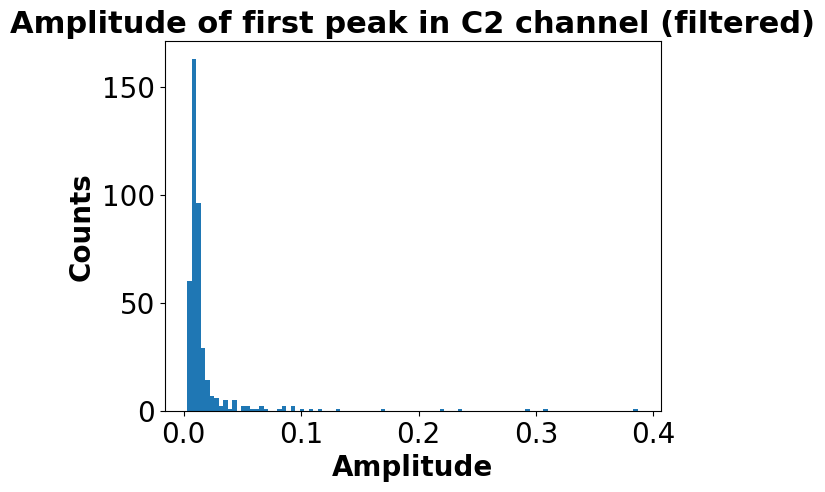

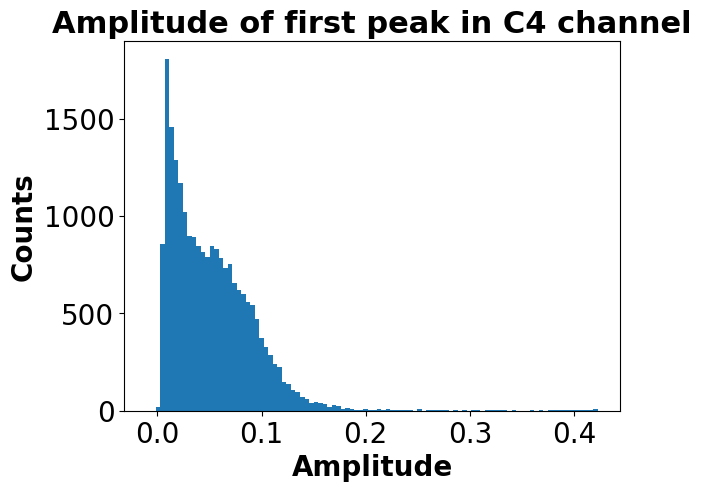

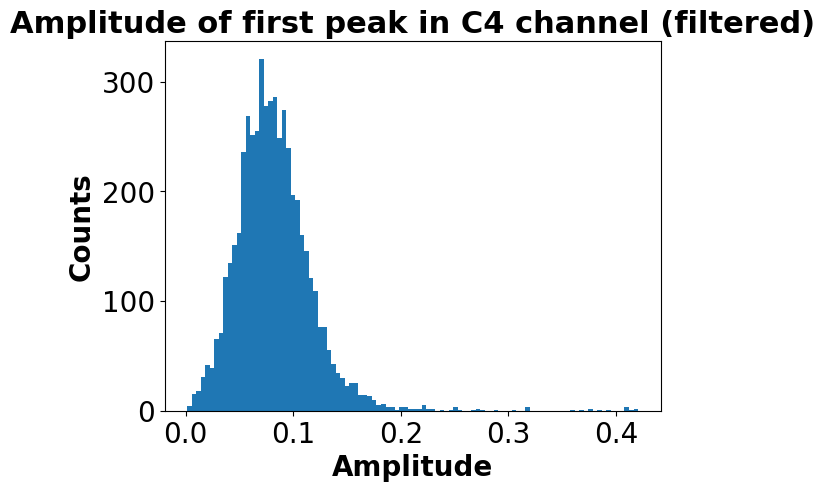

In [11]:
for channel in ['C1', 'C2', 'C4']:
    first_ampls = df[f'peakparam_{channel}/peakparam_{channel}.ampl']
    df[f'peakparam_{channel}/peakparam_{channel}.ampl_filtered'] = first_ampls.apply(lambda x: x if (x > min_ampl) & (x < max_ampl) else np.nan)
    first_ampls = np.array(first_ampls)
    first_ampls_filtered = first_ampls[(first_ampls > min_ampl) & (first_ampls < max_ampl)]
    first_ampls_outliers = first_ampls[(first_ampls < min_ampl) | (first_ampls > max_ampl)]
    # Update the dataframe with the filtered amplitudes

    print(f'{channel} Number of outliers: {len(first_ampls_outliers)} of {len(first_ampls)}')
    print(f'{channel} Number after filter: {len(first_ampls_filtered)} of {len(first_ampls)}')
    #plot each channels amplitude in a histogram
    #print range of amplitudes
    print(f'{channel} channel: min = {np.nanmin(first_ampls_filtered)}, max = {np.nanmax(first_ampls_filtered)}')
    fig, ax = plt.subplots()
    ax.hist(first_ampls_filtered, bins=100)
    ax.set_title(f'Amplitude of first peak in {channel} channel')
    ax.set_xlabel('Amplitude')
    ax.set_ylabel('Counts')

    print(filter_dict[channel])
    filtered_first_ampls = first_ampls[filter_dict[channel]]
    filtered_first_ampls = filtered_first_ampls[(filtered_first_ampls > min_ampl) & (filtered_first_ampls < max_ampl)]
    print(f'{channel} channel: min = {np.nanmin(filtered_first_ampls)}, max = {np.nanmax(filtered_first_ampls)}')
    fig, ax = plt.subplots()
    ax.hist(filtered_first_ampls, bins=100)
    ax.set_title(f'Amplitude of first peak in {channel} channel (filtered)')
    ax.set_xlabel('Amplitude')
    ax.set_ylabel('Counts')
plt.show()


C1 Number of outliers: 25984 of 25984
C2 Number of outliers: 1 of 25984
C2 channel: min = 0.004009692519903183, max = 0.386275645699352
C4 Number of outliers: 2 of 25984
C4 channel: min = 0.004107646364718673, max = 0.3864324754104018


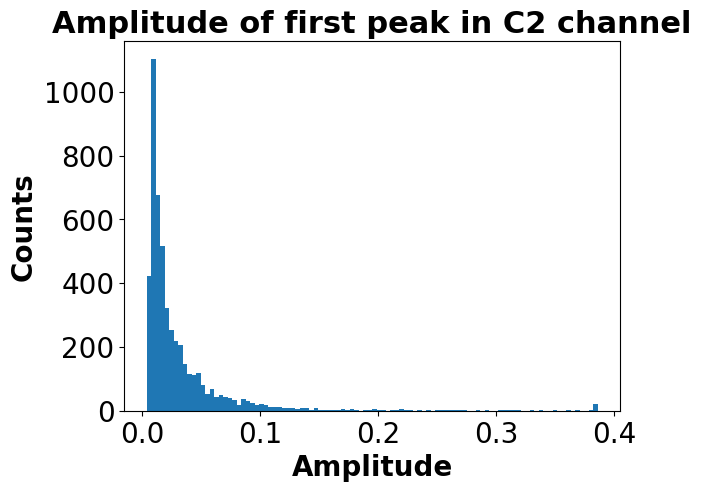

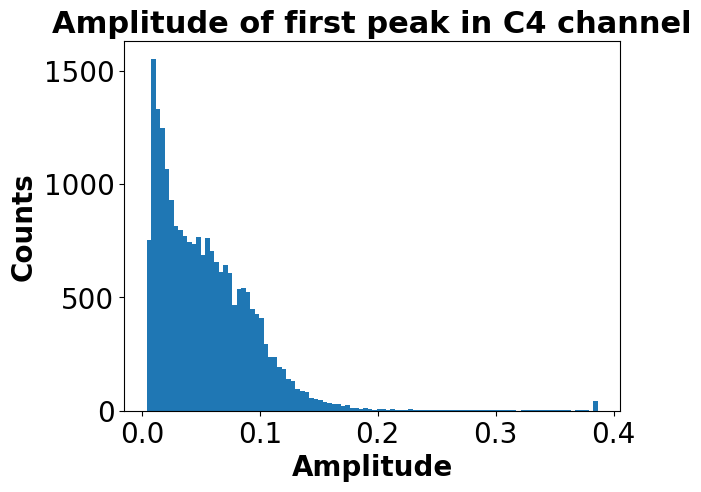

In [12]:
for channel in ['C1', 'C2', 'C4']:
    first_dampls = df[f'peakparam_{channel}/peakparam_{channel}.dampl']

    df[f'peakparam_{channel}/peakparam_{channel}.dampl_filtered'] = first_dampls.apply(lambda x: x if (x > min_ampl) & (x < max_ampl) else np.nan)
    first_dampls = np.array(first_dampls)
    first_dampls_filtered = first_dampls[(first_dampls > min_ampl) & (first_dampls < max_ampl)]
    first_dampls_outliers = first_dampls[(first_dampls < min_ampl) | (first_dampls > max_ampl)]
    print(f'{channel} Number of outliers: {len(first_dampls_outliers)} of {len(first_dampls)}')

    #plot each channels amplitude in a histogram
    #print range of amplitudes
    if len(first_dampls_filtered) <= 0: continue
    print(f'{channel} channel: min = {np.nanmin(first_dampls_filtered)}, max = {np.nanmax(first_dampls_filtered)}')
    fig, ax = plt.subplots()
    ax.hist(first_dampls_filtered, bins=100)
    ax.set_title(f'Amplitude of first peak in {channel} channel')
    ax.set_xlabel('Amplitude')
    ax.set_ylabel('Counts')
plt.show()

In [13]:
print(df.head())

        hitX_C1    hitY_C1  peakparam_C1/peakparam_C1.ampl  \
4416  35.293076  28.785038                        0.191332   
4417  25.653530  28.127159                        0.311535   
4418  26.117359  29.403099                        0.319465   
4419        NaN        NaN                        0.301462   
4420  31.524521  25.177364                        0.273322   

      peakparam_C1/peakparam_C1.dampl  peakparam_C1/peakparam_C1.charge  \
4416                           -999.0                          0.133860   
4417                           -999.0                          0.203303   
4418                           -999.0                          0.219874   
4419                           -999.0                          0.211156   
4420                           -999.0                          0.186704   

      peakparam_C1/peakparam_C1.echargefit  \
4416                               -9999.0   
4417                               -9999.0   
4418                               -99

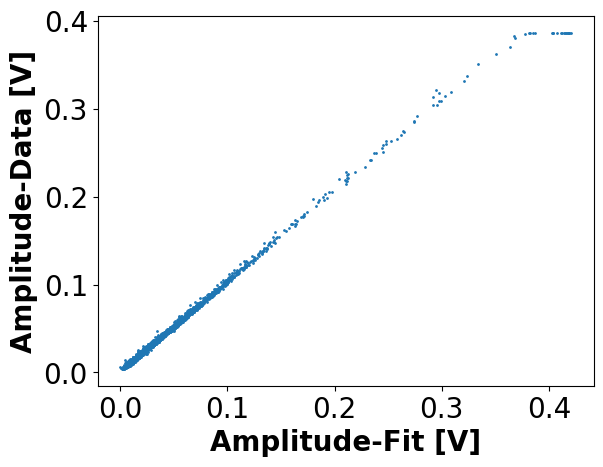

In [14]:
#correlation plot of amplitudes and damplitudes for channel C2 and C4
fig, ax = plt.subplots()
ax.scatter(df['peakparam_C2/peakparam_C2.ampl_filtered'], df['peakparam_C2/peakparam_C2.dampl_filtered'], s=1)
ax.set_title('')
ax.set_xlabel('Amplitude-Fit [V]')
ax.set_ylabel('Amplitude-Data [V]')
plt.show()

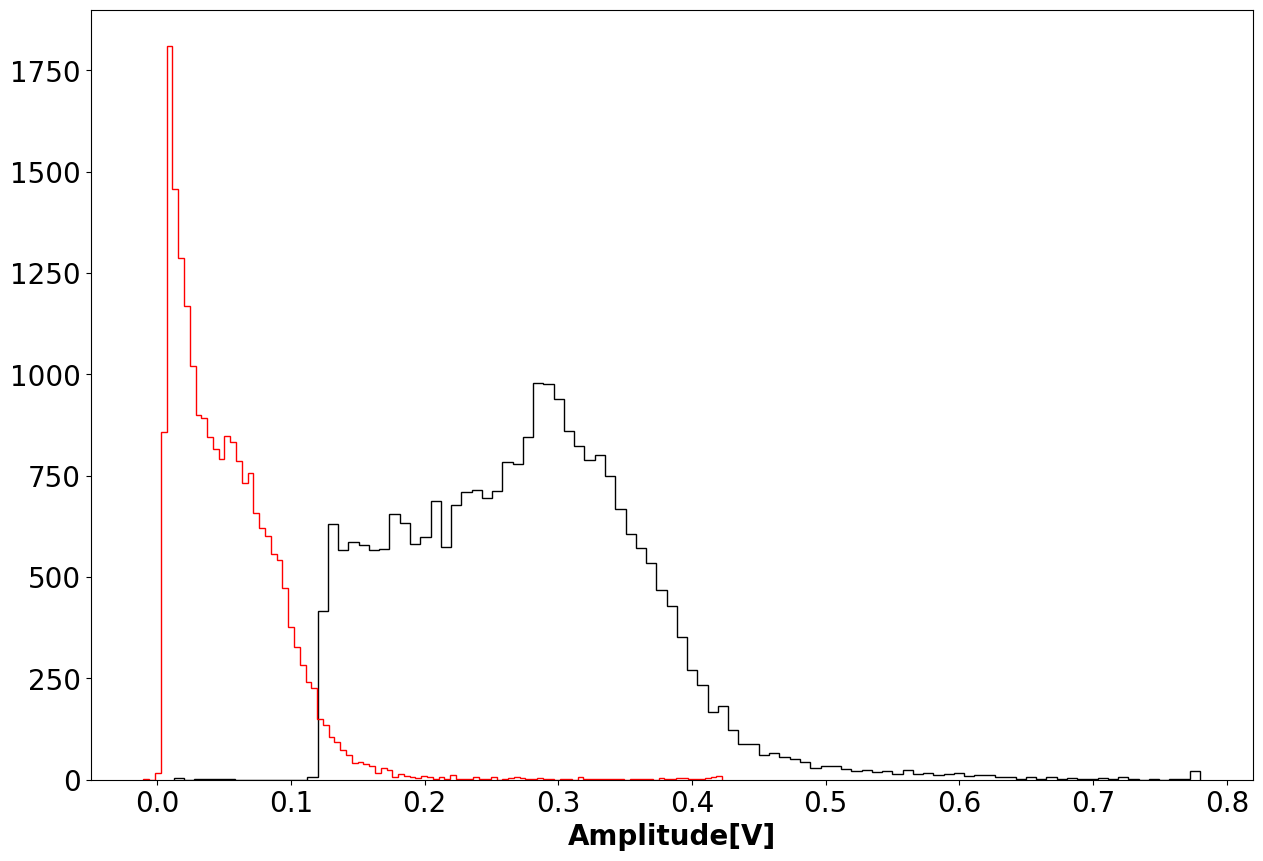

In [15]:
#make a plot with c1 and c4 amplitudes at the same graph
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(df['peakparam_C1/peakparam_C1.ampl_filtered'], bins=100, histtype='step', color='black', lw=2, label=f'MCP-1')
ax.hist(df['peakparam_C4/peakparam_C4.ampl_filtered'], bins=100, histtype='step', color='red', lw=2, label=f'MM-pad0')
ax.set_title('')
ax.set_xlabel('Amplitude[V]')
ax.set_ylabel('')
plt.show()


C1 Number of outliers: 0 of 25984
C1 Number after filter: 25984 of 25984
C1 channel: min = 0.0067010960068495315, max = 1.1877907654227633
C2 Number of outliers: 4 of 25984
C2 Number after filter: 4984 of 25984
C2 channel: min = -0.07169024845375609, max = 19.762735262968327
C4 Number of outliers: 9 of 25984
C4 Number after filter: 21772 of 25984
C4 channel: min = -0.22741424318318434, max = 31.724111593823345


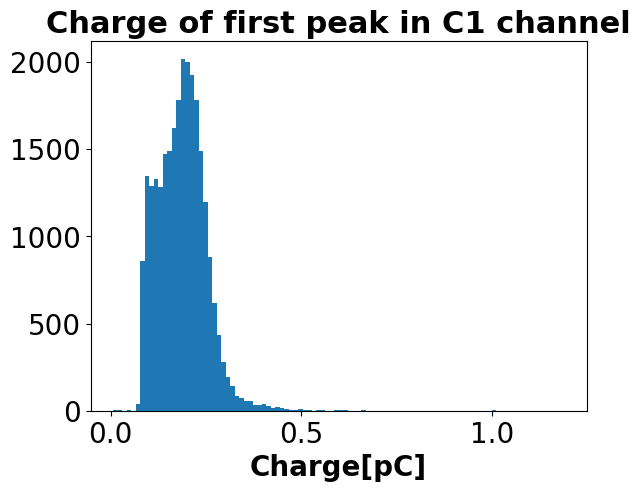

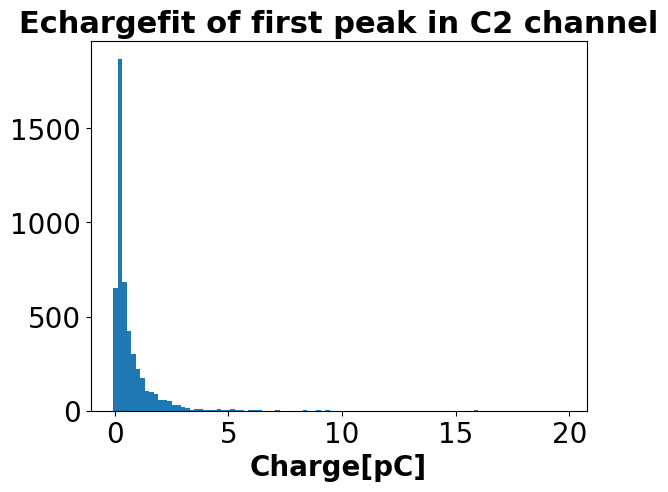

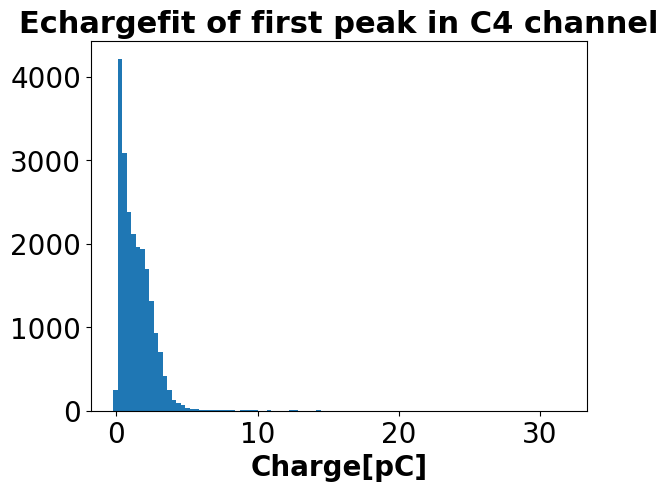

In [16]:
for channel in ['C1','C2', 'C4']:
    if channel == 'C1':
        first_charges = df[f'peakparam_{channel}/peakparam_{channel}.charge']
        df[f'peakparam_{channel}/peakparam_{channel}.charge_filtered'] = first_charges.apply(lambda x: x if (x > min_charge) & (x < max_charge) else np.nan)
        first_charges = np.array(first_charges)
        first_charges_filtered = first_charges[(first_charges > min_charge) & (first_charges < max_charge)]
        first_charges_outliers = first_charges[(first_charges< min_charge) | (first_charges > max_charge)]
    else:
        first_charges = df[f'peakparam_{channel}/peakparam_{channel}.echargefit']
        df[f'peakparam_{channel}/peakparam_{channel}.echargefit_filtered'] = first_charges.apply(lambda x: x if (x > min_charge) & (x < max_charge) else np.nan)

        first_charges = np.array(first_charges)
        first_charges_filtered = first_charges[(first_charges > min_charge) & (first_charges < max_charge)]
        first_charges_outliers = first_charges[(first_charges< min_charge) | (first_charges > max_charge)]
    # Update the dataframe with the filtered amplitudes

    print(f'{channel} Number of outliers: {len(first_charges_outliers)} of {len(first_charges)}')
    print(f'{channel} Number after filter: {len(first_charges_filtered)} of {len(first_charges)}')
    #plot each channels amplitude in a histogram
    #print range of amplitudes
    print(f'{channel} channel: min = {np.nanmin(first_charges_filtered)}, max = {np.nanmax(first_charges_filtered)}')
    fig, ax = plt.subplots()
    ax.hist(first_charges_filtered, bins=100)
    if channel == 'C1':
        ax.set_title(f'Charge of first peak in {channel} channel')
    else:
        ax.set_title(f'Echargefit of first peak in {channel} channel')
    ax.set_xlabel('Charge[pC]')
    ax.set_ylabel('')
plt.show()

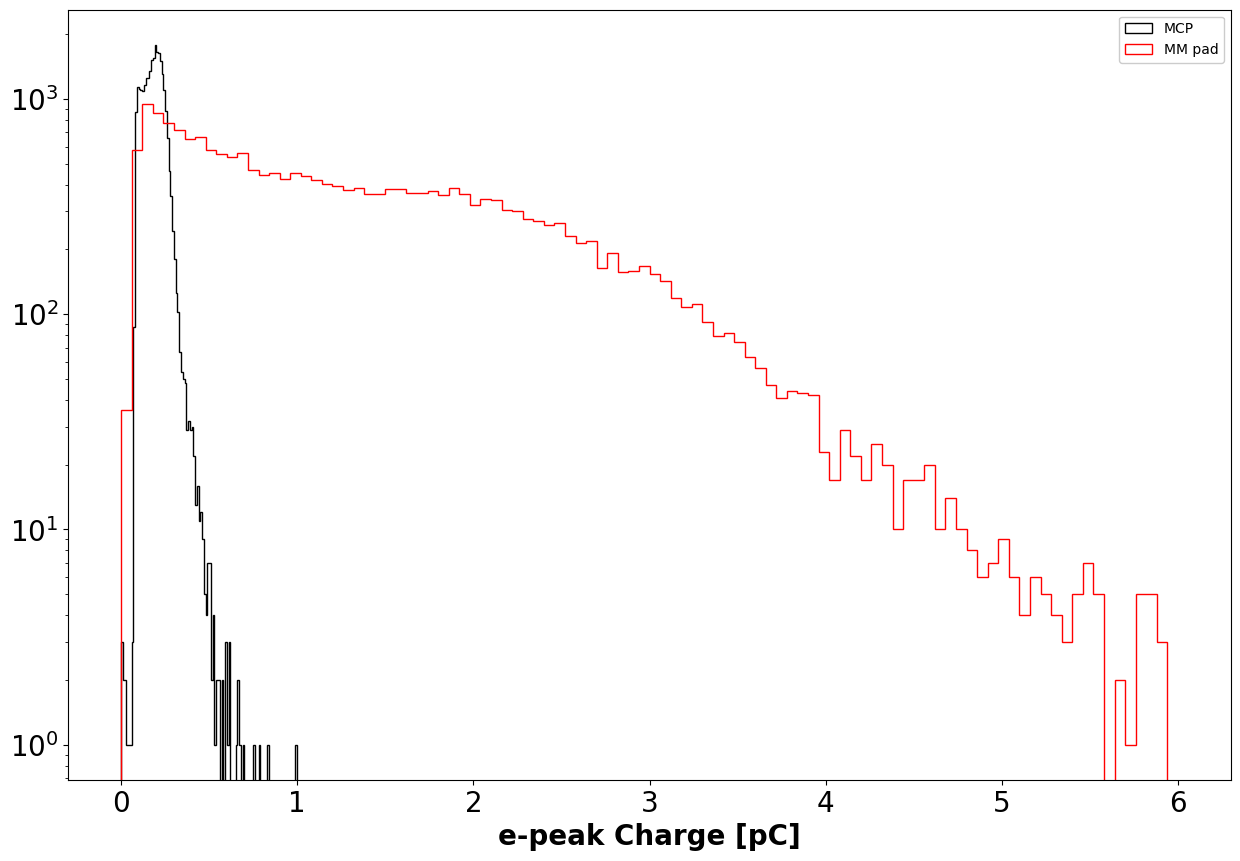

In [17]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mcp_qs)):
axs.hist(df[f'peakparam_C1/peakparam_C1.charge_filtered'], bins=100, range=(0.0, 1.0), histtype='step', color='black', lw=2, label=f'MCP')
axs.hist(df[f'peakparam_C4/peakparam_C4.echargefit_filtered'], bins=100, range=(0.0, 6.0), histtype='step', color='red', lw=2, label=f'MM pad')
axs.set_yscale('log')
axs.set_xlabel('e-peak Charge [pC]')
axs.set_title('')
axs.legend()
plt.show()

C1 Number of outliers: 0 of 25984
C1 Number after filter: 25984 of 25984
C1 channel: min = 0.0067010960068495315, max = 1.1877907654227633
C2 Number of outliers: 5 of 25984
C2 Number after filter: 4983 of 25984
C2 channel: min = 0.13149981795361282, max = 97.66794550557336
C4 Number of outliers: 11 of 25984
C4 Number after filter: 21770 of 25984
C4 channel: min = 0.20159773797738173, max = 95.33508035433051


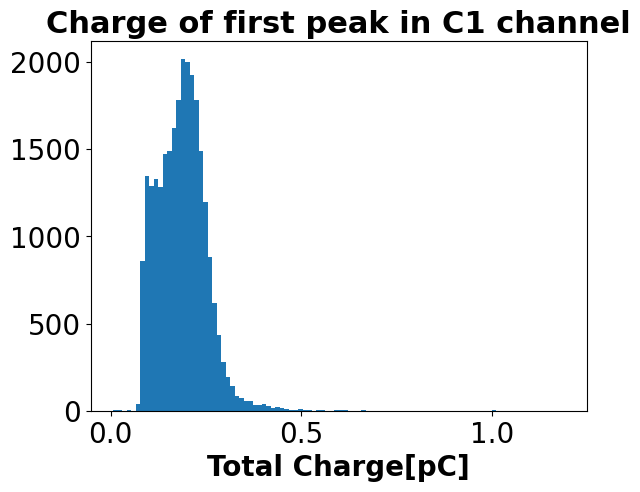

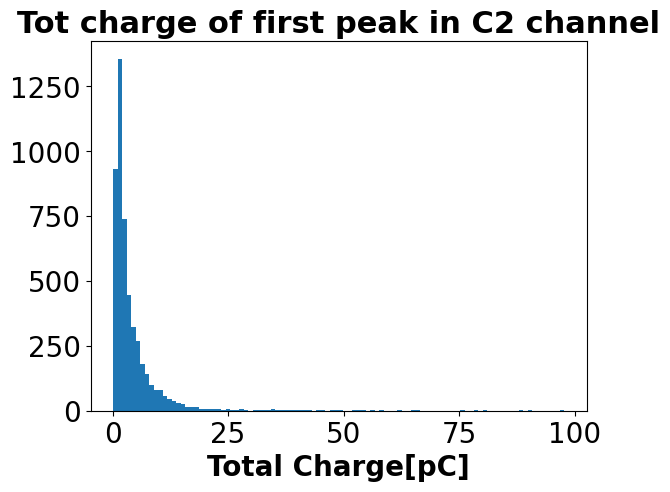

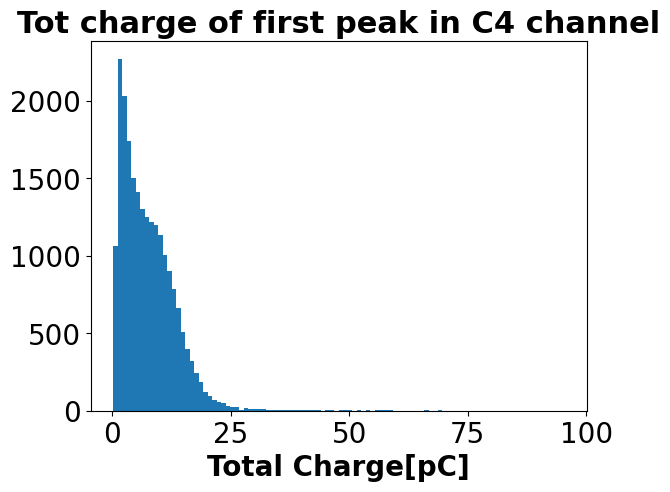

In [18]:
for channel in ['C1','C2', 'C4']:
    if channel == 'C1':
        first_charges = df[f'peakparam_{channel}/peakparam_{channel}.charge']
        df[f'peakparam_{channel}/peakparam_{channel}.charge_filtered'] = first_charges.apply(lambda x: x if (x > min_charge_tot) & (x < max_charge_tot) else np.nan)
        first_charges = np.array(first_charges)
        first_charges_filtered = first_charges[(first_charges > min_charge_tot) & (first_charges < max_charge_tot)]
        first_charges_outliers = first_charges[(first_charges< min_charge_tot) | (first_charges > max_charge_tot)]
    else:
        first_charges = df[f'peakparam_{channel}/peakparam_{channel}.totcharge']
        df[f'peakparam_{channel}/peakparam_{channel}.totcharge_filtered'] = first_charges.apply(lambda x: x if (x > min_charge_tot) & (x < max_charge_tot) else np.nan)

        first_charges = np.array(first_charges)
        first_charges_filtered = first_charges[(first_charges > min_charge_tot) & (first_charges < max_charge_tot)]
        first_charges_outliers = first_charges[(first_charges< min_charge_tot) | (first_charges > max_charge_tot)]
    # Update the dataframe with the filtered amplitudes

    print(f'{channel} Number of outliers: {len(first_charges_outliers)} of {len(first_charges)}')
    print(f'{channel} Number after filter: {len(first_charges_filtered)} of {len(first_charges)}')
    #plot each channels amplitude in a histogram
    #print range of amplitudes
    print(f'{channel} channel: min = {np.nanmin(first_charges_filtered)}, max = {np.nanmax(first_charges_filtered)}')
    fig, ax = plt.subplots()
    ax.hist(first_charges_filtered, bins=100)
    if channel == 'C1':
        ax.set_title(f'Charge of first peak in {channel} channel')
    else:
        ax.set_title(f'Tot charge of first peak in {channel} channel')
    ax.set_xlabel('Total Charge[pC]')
    ax.set_ylabel('')
plt.show()

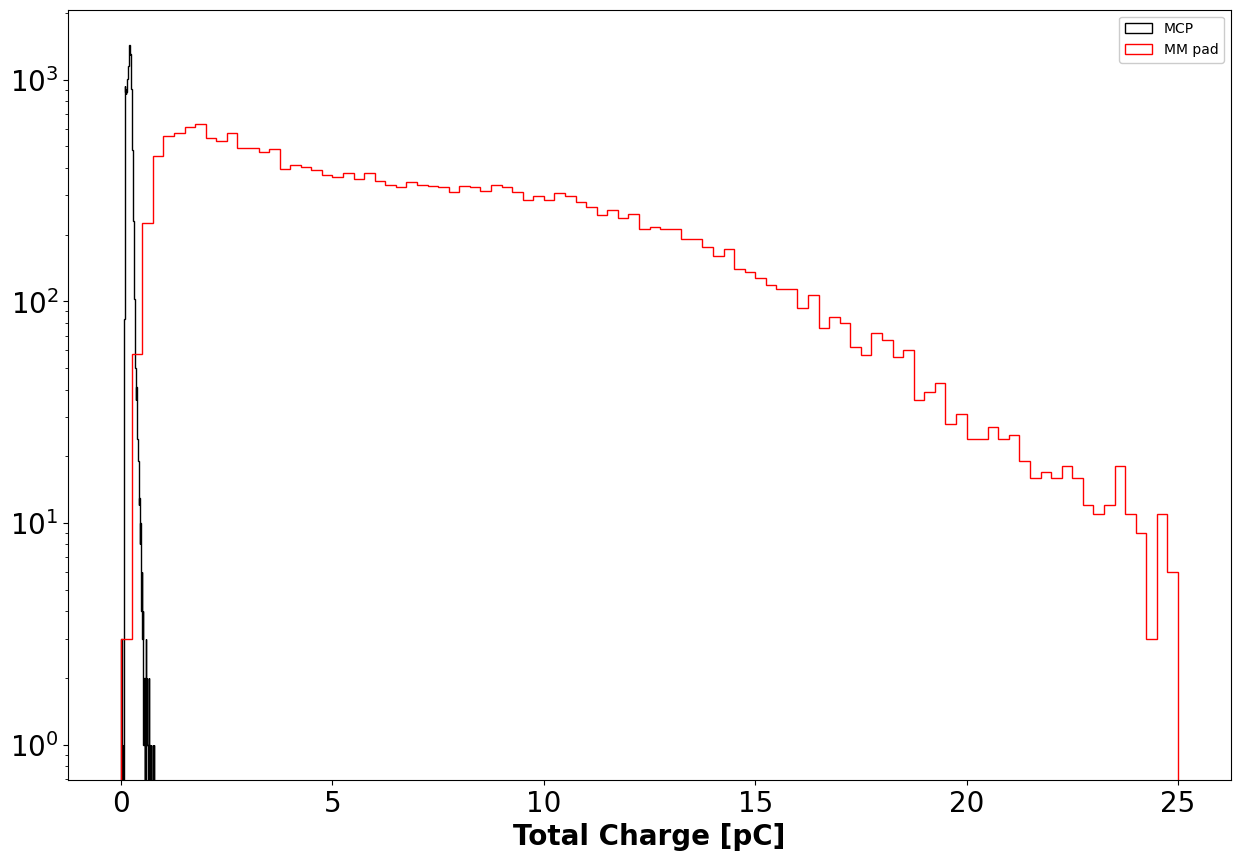

In [19]:
fig, axs = plt.subplots(figsize=(15, 10))
#for i in range(len(mcp_qs)):
axs.hist(df[f'peakparam_C1/peakparam_C1.charge_filtered'], bins=100, range=(0.0, 0.8), histtype='step', color='black', lw=2, label=f'MCP')
axs.hist(df[f'peakparam_C4/peakparam_C4.totcharge_filtered'], bins=100, range=(0.0, 25.0), histtype='step', color='red', lw=2, label=f'MM pad')
axs.set_yscale('log')
axs.set_xlabel('Total Charge [pC]')
axs.set_title('')
axs.legend()
plt.show()

Up Rejects:
        hitX_C1    hitY_C1  peakparam_C1/peakparam_C1.ampl  \
4444  27.797491  23.943296                        0.458306   
4492  24.579620  28.040747                        0.237517   
4504  34.008106  24.337193                        0.306263   
4517  28.840000  27.333103                        0.371106   
4521  28.431326  20.973377                        0.147619   

      peakparam_C1/peakparam_C1.dampl  peakparam_C1/peakparam_C1.charge  \
4444                           -999.0                          0.317773   
4492                           -999.0                          0.161774   
4504                           -999.0                          0.204402   
4517                           -999.0                          0.244336   
4521                           -999.0                          0.102539   

      peakparam_C1/peakparam_C1.echargefit  \
4444                               -9999.0   
4492                               -9999.0   
4504                      

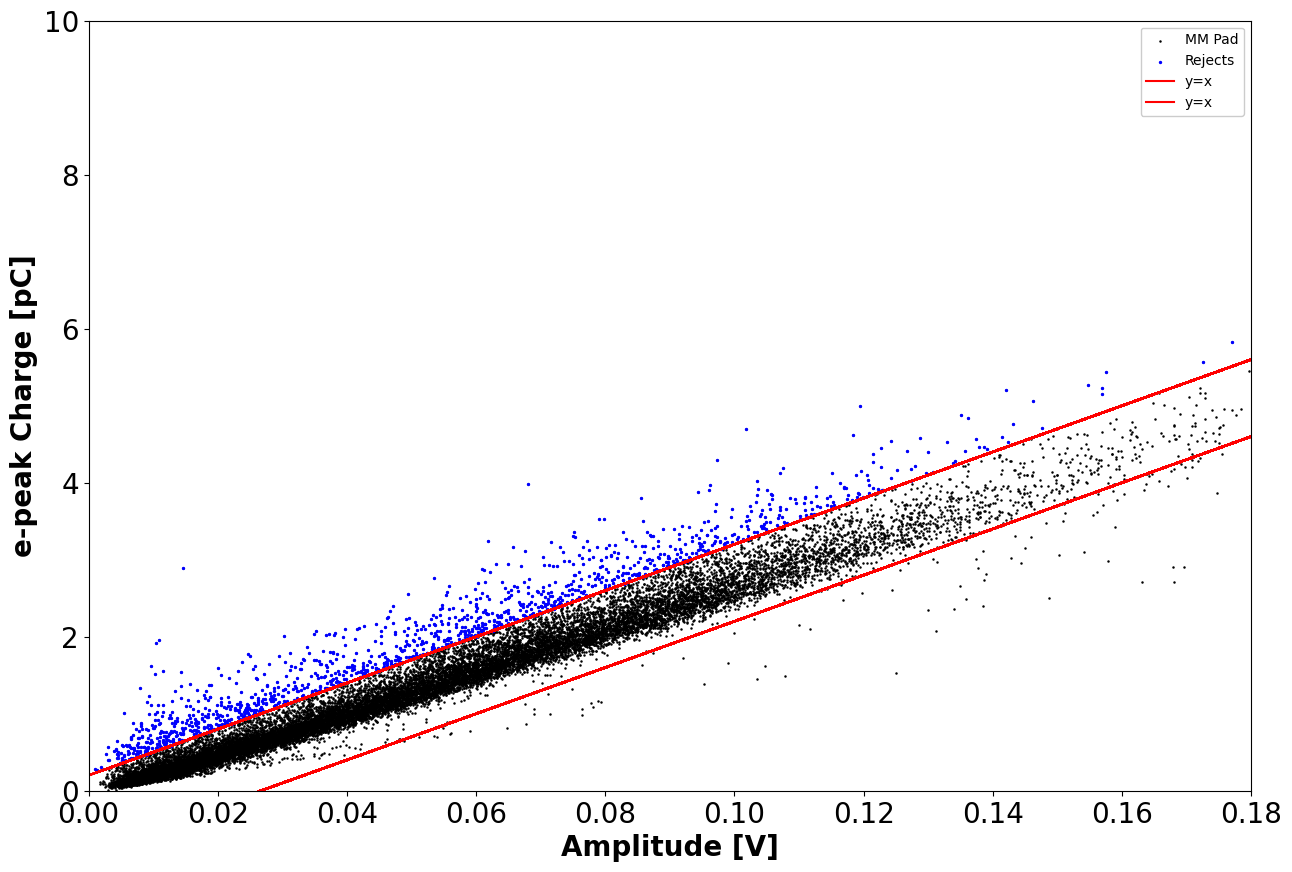

In [20]:
fig, axs = plt.subplots(figsize=(15, 10))

def line(x, a, b):
    return a*x + b

x = df[f'peakparam_C4/peakparam_C4.ampl_filtered']
y = df[f'peakparam_C4/peakparam_C4.echargefit_filtered']

up_slope, up_offset = 30, 0.2
up_rejects_filter = y > line(x, up_slope, up_offset)
up_rejects_x = x[up_rejects_filter]
up_rejects_y = y[up_rejects_filter]

up_rejects_df = df[up_rejects_filter]
print('Up Rejects:')
print(up_rejects_df.head())

#for i in range(len(mm_vs)):
axs.scatter(df[f'peakparam_C4/peakparam_C4.ampl_filtered'], df[f'peakparam_C4/peakparam_C4.echargefit_filtered'], s=0.6, color='black', label=f'MM Pad')
axs.scatter(up_rejects_x, up_rejects_y, s=2, color='blue', label=f'Rejects')
axs.plot(np.array(df[f'peakparam_C4/peakparam_C4.ampl_filtered']), line(np.array(df[f'peakparam_C4/peakparam_C4.ampl_filtered']), 30, 0.2), color='red', label='y=x')
axs.plot(df[f'peakparam_C4/peakparam_C4.ampl_filtered'], line(df[f'peakparam_C4/peakparam_C4.ampl_filtered'], 30, -0.8), color='red', label='y=x')

axs.set_xlabel('Amplitude [V]')
axs.set_ylabel('e-peak Charge [pC]')
axs.set_xlim(0, 0.18)
axs.set_ylim(0, 10)
axs.legend()

plt.show()

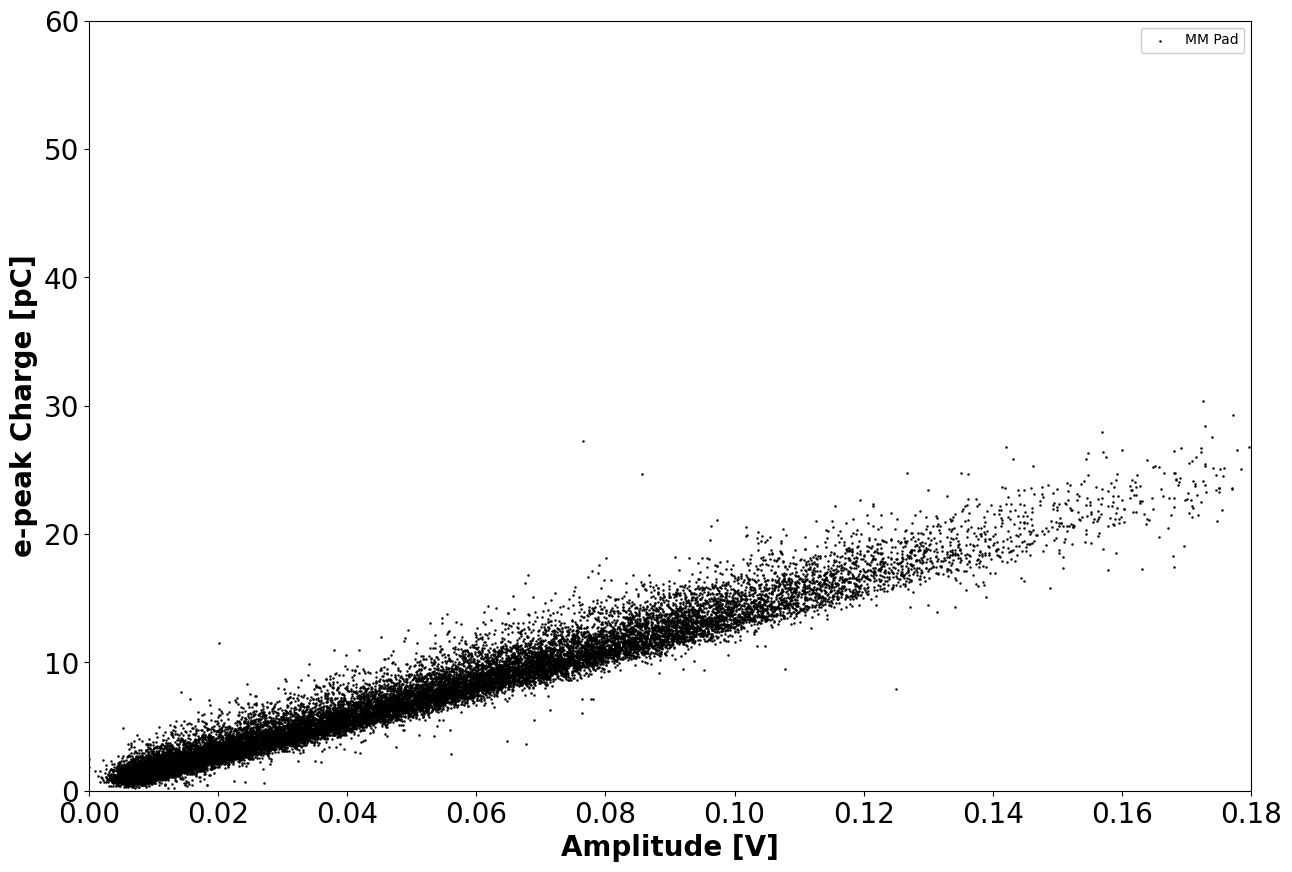

In [21]:
fig, axs = plt.subplots(figsize=(15, 10))

#for i in range(len(mm_vs)):
axs.scatter(df[f'peakparam_C4/peakparam_C4.ampl_filtered'], df[f'peakparam_C4/peakparam_C4.totcharge_filtered'], s=0.6, color='black', label=f'MM Pad')

axs.set_xlabel('Amplitude [V]')
axs.set_ylabel('e-peak Charge [pC]')
axs.set_xlim(0, 0.18)
axs.set_ylim(0, 60)
axs.legend()

plt.show()

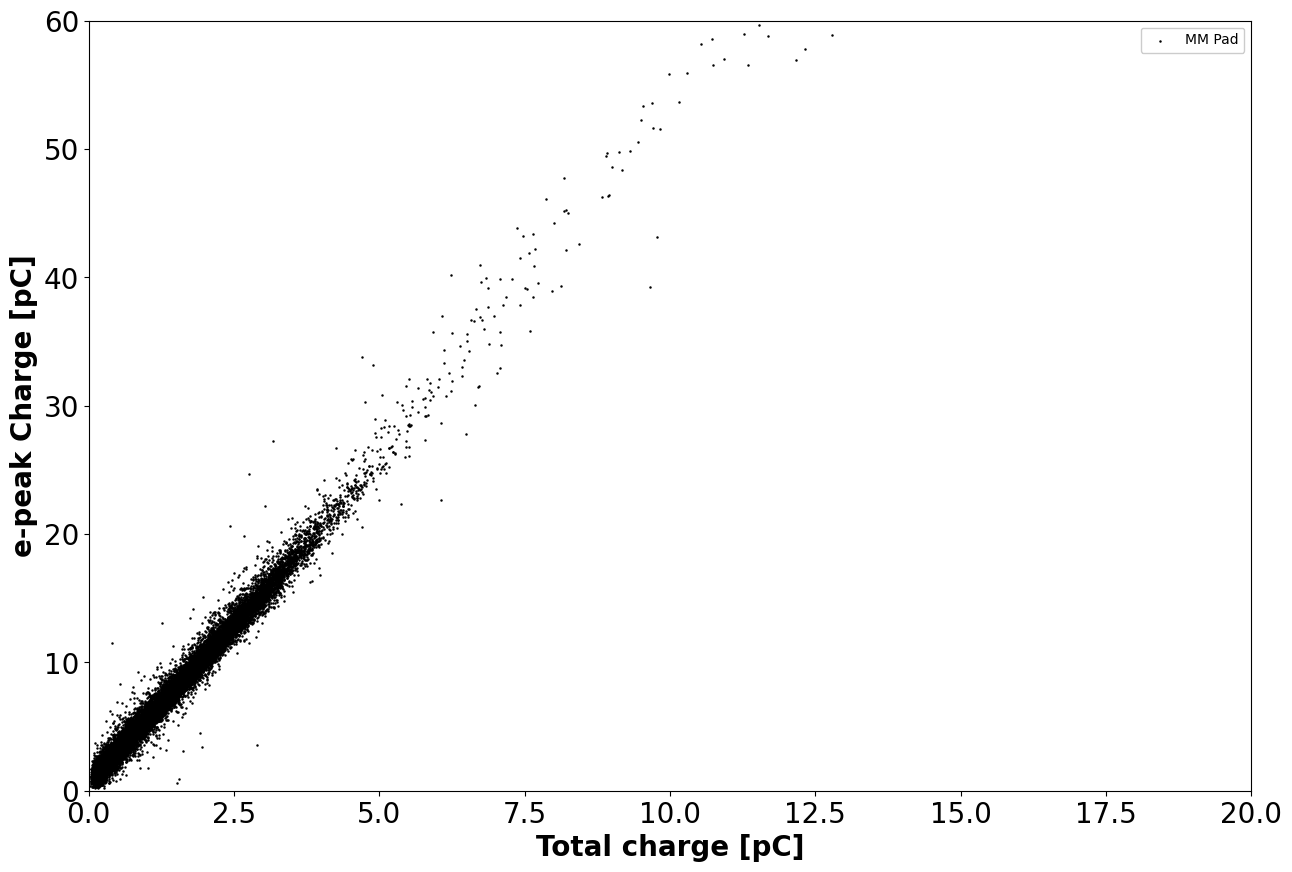

In [22]:
fig, axs = plt.subplots(figsize=(15, 10))

#for i in range(len(mm_vs)):
axs.scatter(df[f'peakparam_C4/peakparam_C4.echargefit_filtered'], df[f'peakparam_C4/peakparam_C4.totcharge_filtered'], s=0.6, color='black', label=f'MM Pad')

axs.set_xlabel('Total charge [pC]')
axs.set_ylabel('e-peak Charge [pC]')
axs.set_xlim(0, 20)
axs.set_ylim(0, 60)
axs.legend()

plt.show()

In [26]:
charge_col = f'peakparam_C1/peakparam_C1.charge_filtered'
charge_cut_low=0
charge_cut_high=100
basic_charge_cut = pd.Series(True, index=df.index)
if charge_cut_low is not None:
    basic_charge_cut &= df[charge_col] > charge_cut_low  # Use `&` for element-wise AND
if charge_cut_high is not None:
    basic_charge_cut &= df[charge_col] < charge_cut_high

basic_charge_cut = basic_charge_cut.to_numpy()

xs = df[f'hitX_{channel}'][basic_charge_cut]
ys = df[f'hitY_{channel}'][basic_charge_cut]
charges = df[charge_col][basic_charge_cut]

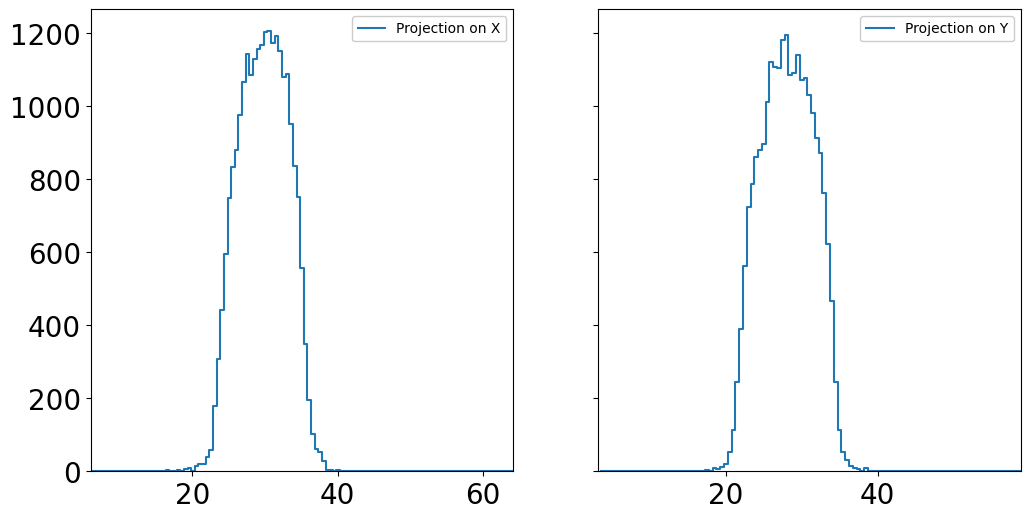

In [28]:
# Define histogram bins
bin_width = 0.5
min_tracks_per_2d_bin = 2
min_avg_charge_per_2d_bin = 0.1
bin_x_min, bin_x_max = np.min(xs), np.max(xs)
bin_y_min, bin_y_max = np.min(ys), np.max(ys)
bins_x = np.arange(bin_x_min, bin_x_max + bin_width, bin_width)
bins_y = np.arange(bin_y_min, bin_y_max + bin_width, bin_width)
bin_centers_x = (bins_x[1:] + bins_x[:-1]) / 2
bin_centers_y = (bins_y[1:] + bins_y[:-1]) / 2

# Create 2D histogram (track multiplicity)
xytrks, _, _ = np.histogram2d(xs, ys, bins=[bins_x, bins_y])

# Create weighted histogram
xytrksW_sum, _, _ = np.histogram2d(xs, ys, bins=[bins_x, bins_y], weights=charges)

# Create boolean mask for bins where xytrks < x
min_track_mask = xytrks < min_tracks_per_2d_bin

# Set corresponding bins to zero in both histograms
xytrks[min_track_mask] = 0
xytrksW_sum[min_track_mask] = 0

# Normalize by dividing the weighted histogram by the original histogram
xytrksW = xytrksW_sum / np.where(xytrks > 0, xytrks, 1)  # Avoid division by zero

min_avg_charge_mask = xytrksW < min_avg_charge_per_2d_bin

xytrks[min_avg_charge_mask] = 0
xytrksW[min_avg_charge_mask] = 0
xytrksW_sum[min_avg_charge_mask] = 0

# Project 2D track multiplicity histograms to 1D
hist_1d_x = np.sum(xytrks, axis=1)
hist_1d_y = np.sum(xytrks, axis=0)

# Find nonzero bins for dynamic range
nonzero_x = np.nonzero(hist_1d_x)[0]
nonzero_y = np.nonzero(hist_1d_y)[0]

if nonzero_x.size > 0:
    x_min, x_max = bins_x[nonzero_x[0]], bins_x[nonzero_x[-1] + 1]
else:
    x_min, x_max = bins_x[0], bins_x[-1]

if nonzero_y.size > 0:
    y_min, y_max = bins_y[nonzero_y[0]], bins_y[nonzero_y[-1] + 1]
else:
    y_min, y_max = bins_y[0], bins_y[-1]

x_range, y_range = x_max - x_min, y_max - y_min

# Plot 1D of xs (track multiplicity)
fig, axs = plt.subplots(ncols=2, sharey='all', figsize=(12, 6))

axs[0].step(bin_centers_x, hist_1d_x, where='mid', label="Projection on X")
axs[1].step(bin_centers_y, hist_1d_y, where='mid', label="Projection on Y")

extend_range = 0.1
axs[0].set_xlim(x_min - extend_range * x_range, x_max + extend_range * x_range)
axs[1].set_xlim(y_min - extend_range * y_range, y_max + extend_range * y_range)

axs[0].set_ylim(bottom=0)
axs[1].set_ylim(bottom=0)
axs[0].legend()
axs[1].legend()
plt.show()

In [36]:
from scipy.interpolate import interp1d

(198,)
(192,)
(198,)
(192,)
(198,)
(192,)
(198, 192)
(198, 192)
(198,)
(198,)


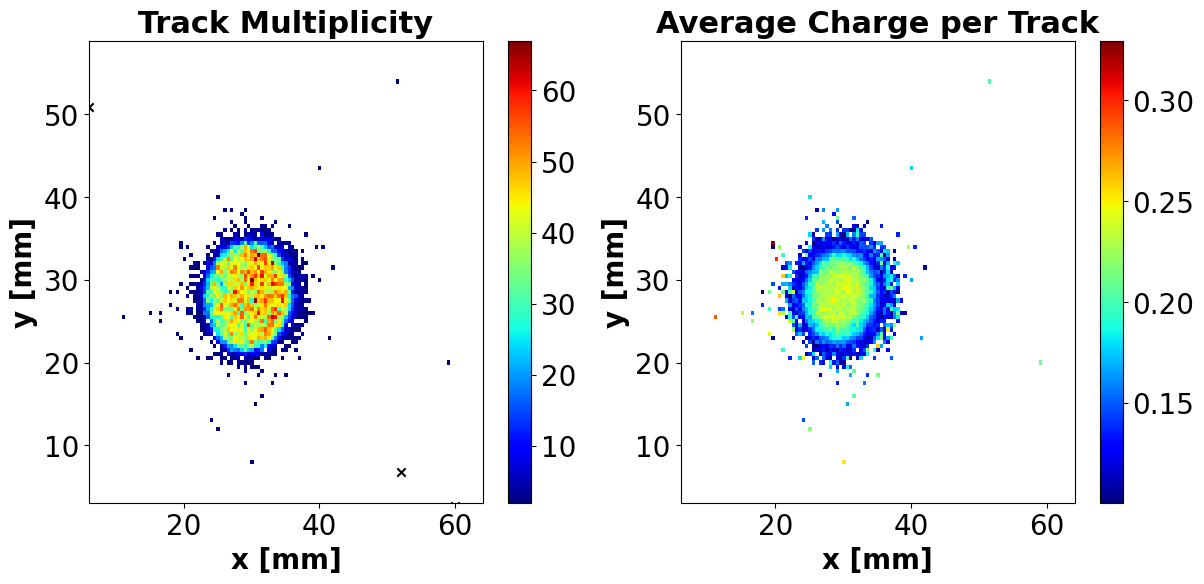

In [42]:
masked_xy_trks = np.ma.masked_less(xytrks, 1)
masked_xy_trksW = np.ma.masked_equal(xytrksW, 0)
sum_x_charge = np.sum(xytrksW_sum, axis=1)
print(sum_x_charge.shape)
sum_y_charge = np.sum(xytrksW_sum, axis=0)
print(sum_y_charge.shape)
sum_x_tracks = np.sum(xytrks, axis=1)
print(sum_x_tracks.shape)
sum_y_tracks = np.sum(xytrks, axis=0)
print(sum_y_tracks.shape)
avg_x_charge = sum_x_charge / np.where(sum_x_tracks > 0, sum_x_tracks, 1)
avg_y_charge = sum_y_charge / np.where(sum_y_tracks > 0, sum_y_tracks, 1)
print(avg_x_charge.shape)
print(avg_y_charge.shape)
print(xytrks.shape) 
print(xytrksW_sum.shape)

f = interp1d(np.linspace(bin_y_min, bin_y_max, len(avg_y_charge)), avg_y_charge, kind='linear', fill_value="extrapolate")
f = interp1d(np.linspace(bin_y_min, bin_y_max, len(sum_y_charge)), sum_y_tracks, kind='linear', bounds_error=False, fill_value="extrapolate")
avg_y_charge_resampled = f(np.linspace(bin_y_min, bin_y_max, len(avg_x_charge)))
sum_y_charge_resampled = f(np.linspace(bin_y_min, bin_y_max, len(sum_x_tracks)))
print(sum_y_charge_resampled.shape)
print(avg_y_charge_resampled.shape)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot xytrks
im1 = axs[0].imshow(masked_xy_trks.T, origin="lower", extent=[bin_x_min, bin_x_max, bin_y_min, bin_y_max],
                    cmap='jet', aspect="auto")
axs[0].set_title("Track Multiplicity")
axs[0].set_xlabel("x [mm]")
axs[0].set_ylabel("y [mm]")
axs[0].scatter(sum_x_tracks, sum_y_charge_resampled, marker='x', c='k')
axs[0].set_xlim(x_min - extend_range * x_range, x_max + extend_range * x_range)
axs[0].set_ylim(y_min - extend_range * y_range, y_max + extend_range * y_range)
fig.colorbar(im1, ax=axs[0])

# Plot xytrksW
# im2 = axs[1].imshow(masked_xy_trksW.T, origin="lower", extent=[0, 50, 0, 50], cmap='jet', aspect="auto", vmax=np.max(masked_xy_trksW) / 1.8)
im2 = axs[1].imshow(masked_xy_trksW.T, origin="lower", extent=[bin_x_min, bin_x_max, bin_y_min, bin_y_max],
                    cmap='jet', aspect="auto")
axs[1].set_title("Average Charge per Track")
axs[1].set_xlabel("x [mm]")
axs[1].set_ylabel("y [mm]")
axs[1].scatter(avg_x_charge, avg_y_charge_resampled, marker='x', c='k')
axs[1].set_xlim(x_min - extend_range * x_range, x_max + extend_range * x_range)
axs[1].set_ylim(y_min - extend_range * y_range, y_max + extend_range * y_range)
fig.colorbar(im2, ax=axs[1])



C1 Pad Center: (29.036 ± 0.060, 26.967 ± 0.057)


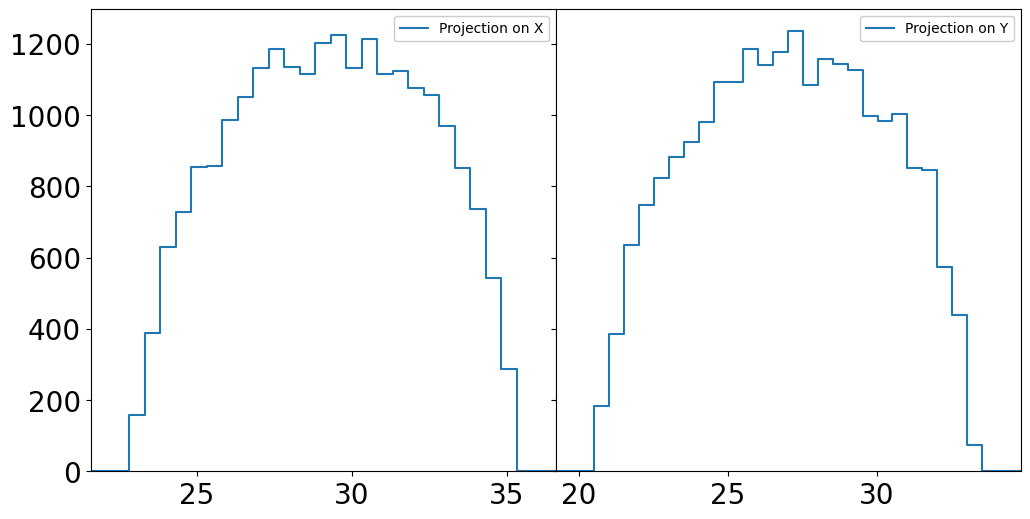

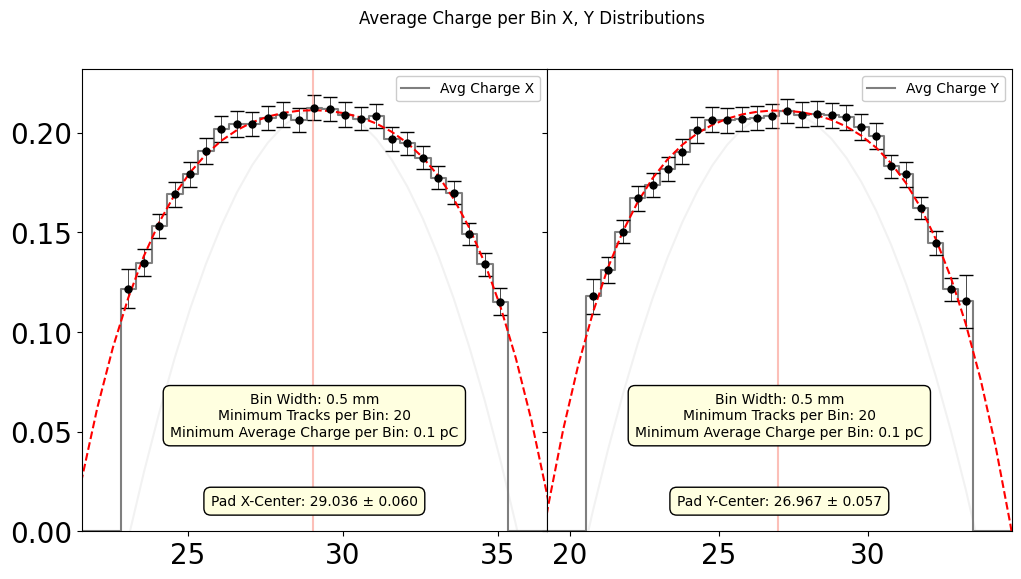

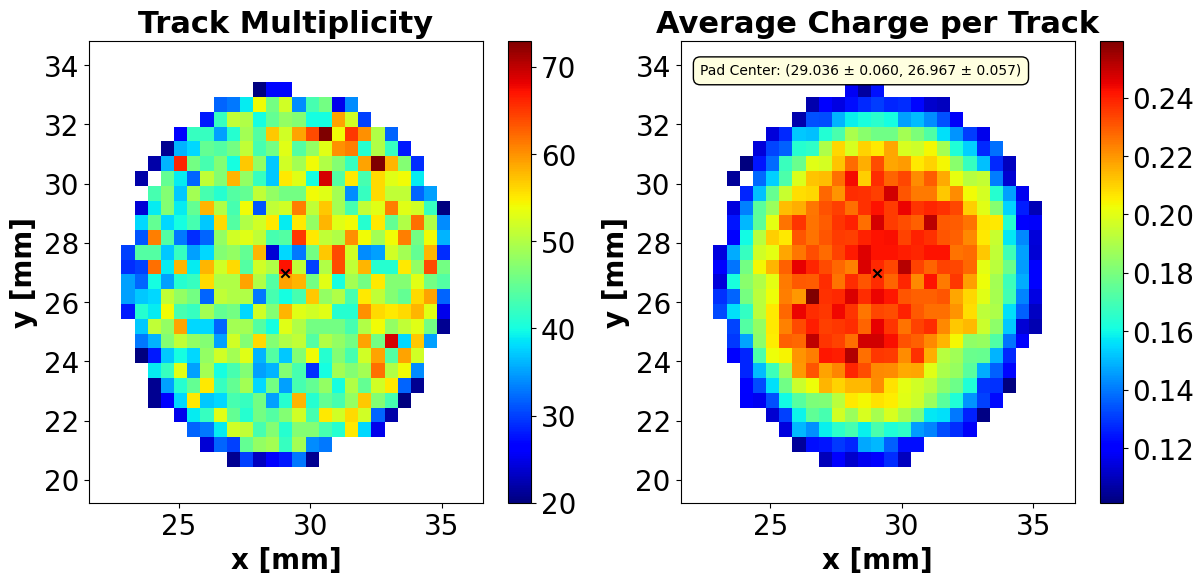

In [43]:
c1_pad_center_measures = get_pad_center(df, 'C1', plot=True, charge_col_name='charge_filtered', charge_cut_low=0, charge_cut_high=2, min_avg_charge_per_2d_bin=0.1)
print(f'C1 Pad Center: ({", ".join([str(xi) for xi in c1_pad_center_measures])})')

C4 Pad Center: (29.138 ± 0.042, 26.619 ± 0.049)


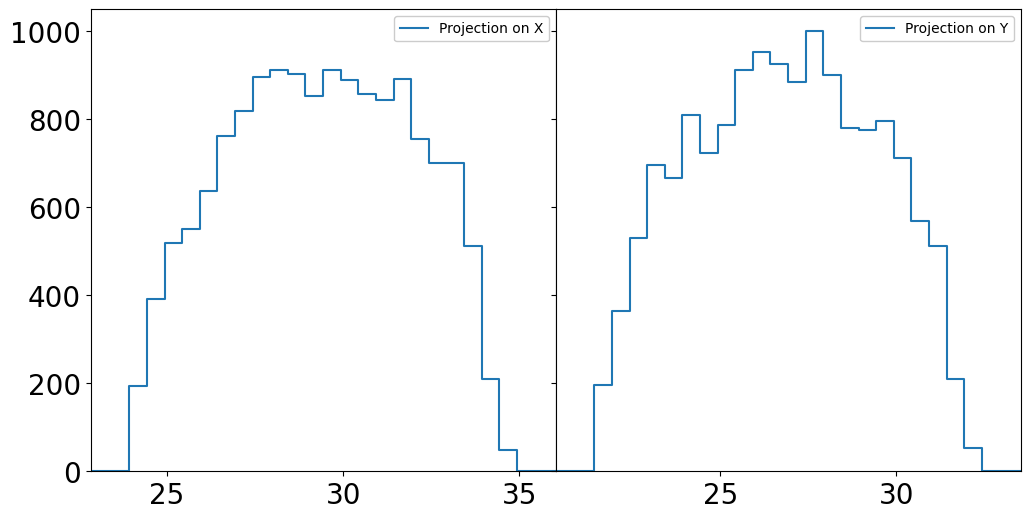

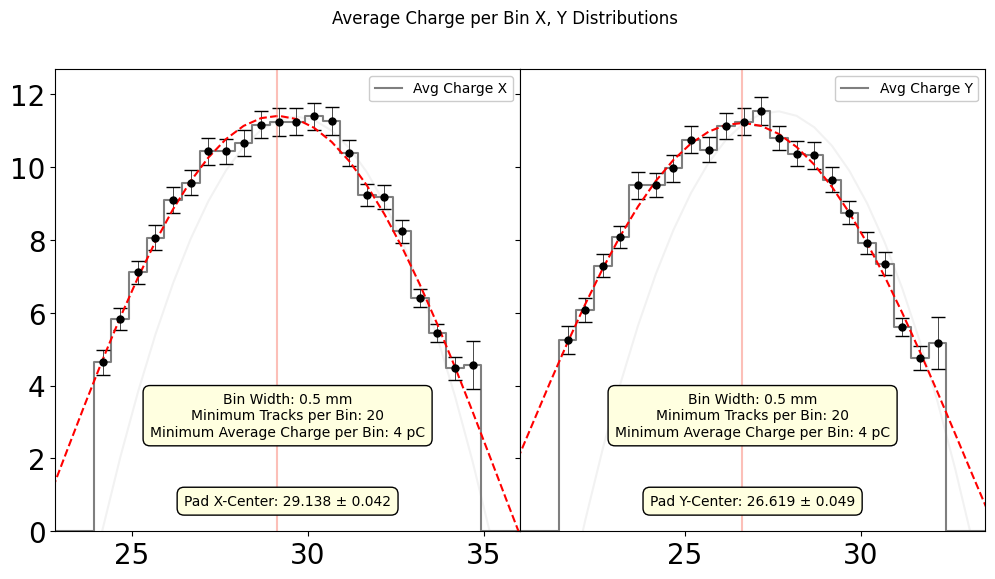

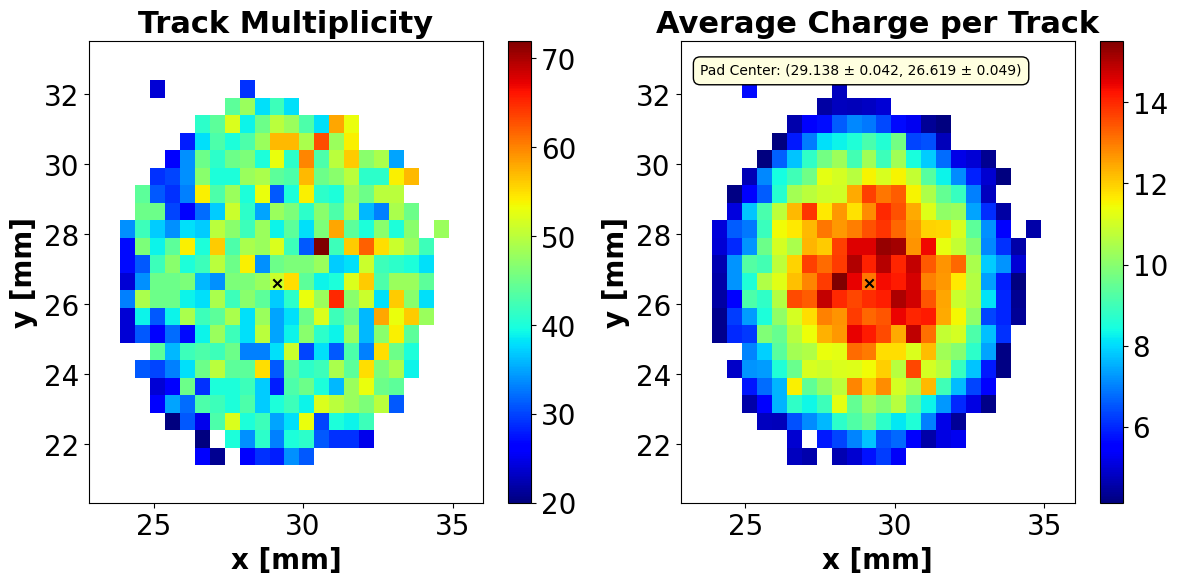

In [44]:
c4_pad_center_measures = get_pad_center(df, 'C4', plot=True, charge_cut_low=0, charge_cut_high=100)
print(f'C4 Pad Center: ({", ".join([str(xi) for xi in c4_pad_center_measures])})')

In [45]:
mm_basic_charge_cut = (0.2 < df['peakparam_C4/peakparam_C4.totcharge_filtered']) & (df['peakparam_C4/peakparam_C4.totcharge_filtered'] < 100)
mcp_basic_charge_cut = (0 < df['peakparam_C1/peakparam_C1.charge_filtered']) & (df['peakparam_C1/peakparam_C1.charge_filtered'] < 2)
good_mm_mcp_charge_events = mm_basic_charge_cut & mcp_basic_charge_cut
xs = df['hitX_C4'][good_mm_mcp_charge_events]
ys = df['hitY_C4'][good_mm_mcp_charge_events]
rs = np.sqrt((xs - c4_pad_center_measures[0].val)**2 + (ys - c4_pad_center_measures[1].val)**2)
charges_all = df['peakparam_C4/peakparam_C4.totcharge_filtered'][good_mm_mcp_charge_events]

print(f'charges_all.shape: {charges_all.shape}')

charges_all.shape: (21770,)


In [ ]:
# time_col = 'tfit20'
time_col = 'tfit20_nb'
# time_col = 'tnaive20'

mm_t20 = df[f'peakparam_C4/peakparam_C4.{time_col}'][good_mm_mcp_charge_events]
mcp_t20 = df[f'peakparam_C1/peakparam_C1.{time_col}'][good_mm_mcp_charge_events]

# Make filter for any nan mm_t20, mcp_t20, or charges

# time_walk_func = time_walk_func_power_law
# p0 = [10, -1.1, 3]
time_walk_func = time_walk_double_exponential
p0 = [1, -1, 1, -1, 4]
# time_walk_func = time_walk_linear
# p0 = [0, 4]

time_diff_all = mm_t20 - mcp_t20
print(f'time_diff_all.shape: {time_diff_all.shape}')
print(time_diff_all)
time_diff_charge_na_filter = ~pd.isna(time_diff_all) & ~pd.isna(charges_all)

rs = np.array(rs[time_diff_charge_na_filter])
xs = np.array(xs[time_diff_charge_na_filter])
ys = np.array(ys[time_diff_charge_na_filter])

time_diff_all = time_diff_all[time_diff_charge_na_filter]
# Get filter for t_diff > 7.5
large_time_diff_mask = time_diff_all > 7.5
time_diff_all = np.array(time_diff_all)
print(charges_all)
charges_all = np.array(charges_all[time_diff_charge_na_filter])
print(charges_all)



time_diff_mask = (time_diff_all < 8) & (time_diff_all > 0)
charges = charges_all[time_diff_mask]
time_diff = time_diff_all[time_diff_mask]

sorted_indices = np.argsort(charges)
charges, time_diff = charges[sorted_indices], time_diff[sorted_indices]

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(charges, bins=100)

fig, ax = plt.subplots(figsize=(8, 5))
binning_t20 = np.arange(180, 250, 1)
ax.hist(mm_t20, bins=binning_t20, alpha=0.5, color='green', label='MM')
ax.hist(mcp_t20, bins=binning_t20, alpha=0.5, color='blue', label='MCP')
ax.legend()

fig, ax = plt.subplots(figsize=(8, 5))
binning_t20_diff = np.arange(0, 15, 0.1)
ax.hist(time_diff, bins=binning_t20_diff)

fig, ax = plt.subplots(figsize=(8, 5))
popt, pcov = cf(time_walk_func, charges, time_diff, p0=p0, maxfev=10000)
ax.plot(charges, time_walk_func(charges, *p0), color='gray', alpha=0.2)
ax.plot(charges, time_walk_func(charges, *popt), color='red', ls='--')
ax.scatter(charges, time_diff, alpha=0.5)

xs_large_time_diff = xs[large_time_diff_mask]
ys_large_time_diff = ys[large_time_diff_mask]

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(xs_large_time_diff, ys_large_time_diff, alpha=0.5)

n_event_bins = int(len(charges) / 100)
print('n_event_bins:', n_event_bins)
# Split numpy array into
n_gaus_bins = 10
bin_start = 0
plot_individual_bin_gaus_fit = False
avg_charges, med_time_diffs, std_err_time_diffs, gaus_means, gaus_mean_errs = [], [], [], [], []
while bin_start < len(charges) - 1:
    bin_end = bin_start + n_event_bins
    if bin_end > len(charges):
        bin_end = len(charges) - 1
        print(f'{bin_end - bin_start} points in the last bin')
    bin_charges = charges[bin_start:bin_end]
    bin_time_diffs = time_diff[bin_start:bin_end]
    avg_charges.append(np.mean(bin_charges))
    med_time_diffs.append(np.median(bin_time_diffs))
    std_err = np.std(bin_time_diffs) / np.sqrt(len(bin_time_diffs)) if len(bin_time_diffs) > 0 else np.nan
    std_err = std_err if std_err > 0 else 1
    std_err_time_diffs.append(std_err)

    bin_time_diff_hist, bin_time_diff_charge_bin_edges = np.histogram(bin_time_diffs, bins=n_gaus_bins)
    bin_time_diff_charge_bin_centers = (bin_time_diff_charge_bin_edges[1:] + bin_time_diff_charge_bin_edges[:-1]) / 2
    p0_gaus_bin = [np.max(bin_time_diff_hist), np.mean(bin_time_diffs), np.std(bin_time_diffs)]
    try:
        popt_gaus_bin, pcov_gaus_bin = cf(gaus, bin_time_diff_charge_bin_centers, bin_time_diff_hist, p0=p0_gaus_bin, maxfev=10000)
        perr_gaus_bin = np.sqrt(np.diag(pcov_gaus_bin))

        if plot_individual_bin_gaus_fit:
            fig, ax = plt.subplots(figsize=(8, 5))
            bin_time_diff_charg_bin_widths = np.diff(bin_time_diff_charge_bin_edges)
            ax.bar(bin_time_diff_charge_bin_centers, bin_time_diff_hist, width=bin_time_diff_charg_bin_widths, color='black')
            x_plot = np.linspace(bin_time_diff_charge_bin_edges[0], bin_time_diff_charge_bin_edges[-1], 200)
            ax.plot(x_plot, gaus(x_plot, *p0_gaus_bin), color='gray', alpha=0.2)
            ax.plot(x_plot, gaus(x_plot, *popt_gaus_bin), color='red')
            ax.set_title(f'Fit from {charges[bin_start]:.2f} pC to {charges[bin_end]:2f} pC')

        gaus_means.append(popt_gaus_bin[1])
        gaus_mean_errs.append(perr_gaus_bin[1])

    except RuntimeError:
        print(f'gaus_bin_hist failed for bin {charges[bin_start]:.2f} pC to {charges[bin_end]:2f} pC')
        gaus_means.append(p0_gaus_bin[1])
        gaus_mean_errs.append(p0_gaus_bin[1])

    bin_start = bin_end

fig, ax = plt.subplots(figsize=(8, 5))
popt_dyn_bin, pcov_dyn_bin = cf(time_walk_func, avg_charges, med_time_diffs, sigma=std_err_time_diffs, absolute_sigma=True, p0=popt, maxfev=10000)

ax.errorbar(avg_charges, med_time_diffs, yerr=std_err_time_diffs, fmt='.', color='black', label='Average charges')
ax.plot(charges, time_walk_func(charges, *popt_dyn_bin), ls='--', color='red', label='Dynamic bin')

fig, ax = plt.subplots(figsize=(8, 5))
popt_gaus_fits, pcov_gaus_fits = cf(time_walk_func, avg_charges, gaus_means, sigma=gaus_mean_errs, absolute_sigma=True, p0=popt, maxfev=10000)

ax.errorbar(avg_charges, gaus_means, yerr=gaus_mean_errs, fmt='.', color='black', label='Average charges')
ax.plot(charges, time_walk_func(charges, *popt_gaus_fits), ls='--', color='red', label='Dynamic bin')

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(charges, time_diff, alpha=0.2)
ax.plot(charges, time_walk_func(charges, *popt_dyn_bin), color='red', ls='--', label='Median of Bin Fit')
ax.plot(charges, time_walk_func(charges, *popt_gaus_fits), color='green', ls='--', label='Gaus Fit of Bin Fit')
ax.plot(charges, time_walk_func(charges, *popt), color='blue', ls='--', label='Individual Point Fit')
ax.legend()


In [ ]:
from HexDetector import hex_radius_inner_to_outer

In [ ]:
# Correct time_diff vs charge with parameters from 3 different fits
r_inner = 4.3
r_outer = hex_radius_inner_to_outer(r_inner)
cor_names = ['Individual Points Fit', 'Median of Bin Fit', 'Gaus Fit of Bin Fit']
for cor_popt, cor_name in zip([popt, popt_dyn_bin, popt_gaus_fits], cor_names):
    print(f'{col_name}: {cor_popt}')
    time_diff_cor = time_diff - time_walk_func(charges, *cor_popt)

    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    axs[0].scatter(charges, time_diff_cor, alpha=0.2, label=cor_name)
    axs[1].hist(time_diff_cor, bins=100)
    axs[0].legend()

    time_diff_all_cor = time_diff_all - time_walk_func(charges_all, *cor_popt)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(rs, time_diff_all_cor, alpha=0.2, label=cor_name)
    ax.axvline(r_inner, color='green', ls='--', label='Hex Inner Radius')
    ax.axvline(r_outer, color='orange', ls='--', label='Hex Outer Radius')
    ax.legend()
    ax.set_ylim(-2, 2)
    ax.set_xlim(-1, 10)


In [ ]:
r_inner = 4.3
r_outer = hex_radius_inner_to_outer(r_inner)
time_diff_all_cor = time_diff_all - time_walk_func(charges_all, *popt)

charges_all_filter = charges_all > 2
rs_filter = rs[charges_all_filter]
time_diff_all_cor_filter = time_diff_all_cor[charges_all_filter]

# r_bin_width = 0.5
r_bin_width = 4.0
r_bin_edges = np.arange(0, 8, r_bin_width)
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(rs_filter, time_diff_all_cor_filter, alpha=0.2)
for r_bin_edge in r_bin_edges:
    ax.axvline(r_bin_edge, color='red')
ax.set_xlim(0, 10)
ax.set_ylim(-2, 2)


time_diff_binning = np.arange(-1, 1, 0.02)
r_bin_centers, timing, timing_err = [], [], []
for r_bin_edge in r_bin_edges:
    r_bin_upper_edge = r_bin_edge + r_bin_width
    r_bin_filter = (rs_filter > r_bin_edge) & (rs_filter <= r_bin_upper_edge)
    time_diffs_r_bin = time_diff_all_cor_filter[r_bin_filter]
    # print(r_bin_edge, r_bin_upper_edge, time_diffs_r_bin)
    fig, ax = plt.subplots(figsize=(8, 5))
    bin_time_diff_hist, _, _ = ax.hist(time_diffs_r_bin, bins=time_diff_binning, label=f'{r_bin_edge:.2f} - {r_bin_upper_edge:.2f} mm')
    time_diff_bin_centers = (time_diff_binning[:-1] + time_diff_binning[1:]) / 2

    p0_r_bin = [np.max(bin_time_diff_hist), 0, np.std(time_diffs_r_bin)]
    popt_r_bin, pcov_r_bin = cf(gaus, time_diff_bin_centers, bin_time_diff_hist, p0=p0_r_bin, maxfev=10000)
    popt_r_bin[2] = abs(popt_r_bin[2])
    perr_r_bin = np.sqrt(np.diag(pcov_r_bin))
    meases = [Measure(val, err) for val, err in zip(popt_r_bin, perr_r_bin)]

    fit_str = rf'$A = {meases[0]}$'+ '\n' + rf'$\mu = {meases[1]}$'+ '\n' + rf'$\sigma = {meases[2]}$'

    ax.plot(time_diff_bin_centers, gaus(time_diff_bin_centers, *p0_r_bin), color='gray', alpha=0.2, label='Guess')
    ax.plot(time_diff_bin_centers, gaus(time_diff_bin_centers, *popt_r_bin), color='red', label='Fit')
    ax.annotate(
                fit_str,
                xy=(0.1, 0.9), xycoords='axes fraction',
                ha='left', va='top',
                bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow')
                )
    ax.legend()
    r_bin_centers.append((r_bin_edge + r_bin_upper_edge) / 2)
    timing.append(popt_r_bin[2] * 1e3)
    timing_err.append(perr_r_bin[2] * 1e3)


fig, ax = plt.subplots(figsize=(8, 5))
r_bin_width = r_bin_edges[1] - r_bin_edges[0]
ax.errorbar(r_bin_centers, timing, yerr=timing_err, xerr=r_bin_width / 2, marker='o', color='black', ls='none')
ax.set_xlabel('Radial Distance from Pad Center [mm]')
ax.set_ylabel('Time Resolution [ns]')
ax.set_ylim(bottom=0)




In [ ]:
mm_basic_charge_cut = (0 < df['peakparam_C4/peakparam_C4.echargefit_filtered']) & (df['peakparam_C4/peakparam_C4.echargefit_filtered'] < 100)
mcp_basic_charge_cut = (0 < df['peakparam_C1/peakparam_C1.charge_filtered']) & (df['peakparam_C1/peakparam_C1.charge_filtered'] < 2)
xs = df['hitX_C4'][mm_basic_charge_cut]
ys = df['hitY_C4'][mm_basic_charge_cut]
rs = np.sqrt((xs - c4_pad_center_measures[0].val)**2 + (ys - c4_pad_center_measures[1].val)**2)
charges_all = df['peakparam_C4/peakparam_C4.echargefit_filtered'][mm_basic_charge_cut]

mm_t20 = df['peakparam_C4/peakparam_C4.tfit20'][mm_basic_charge_cut]
mcp_t20 = df['peakparam_C1/peakparam_C1.tfit20'][mcp_basic_charge_cut]
# mm_t20 = df['peakparam_C4/peakparam_C4.tfit20_nb'][mm_basic_charge_cut]
# mcp_t20 = df['peakparam_C1/peakparam_C1.tfit20_nb'][mcp_basic_charge_cut]
# mm_t20 = df['peakparam_C4/peakparam_C4.tnaive20'][mm_basic_charge_cut]
# mcp_t20 = df['peakparam_C1/peakparam_C1.tnaive20'][mcp_basic_charge_cut]

# Make filter for any nan mm_t20, mcp_t20, or charges

# time_walk_func = time_walk_func_power_law
# p0 = [10, -1.1, 3]
time_walk_func = time_walk_double_exponential
p0 = [1, -1, 1, -1, 1]

time_diff_all = mm_t20 - mcp_t20
time_diff_all = np.array(time_diff_all[~pd.isna(time_diff_all)])
charges_all = np.array(charges_all[~pd.isna(time_diff_all)])

# Get filter for t_diff > 7.5
large_time_diff_mask = time_diff_all > 7.5

time_diff_mask = (time_diff_all < 8) & (time_diff_all > 0)
charges = charges_all[time_diff_mask]
time_diff = time_diff_all[time_diff_mask]

sorted_indices = np.argsort(charges)
charges, time_diff = charges[sorted_indices], time_diff[sorted_indices]

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(charges, bins=100)

fig, ax = plt.subplots(figsize=(8, 5))
binning_t20 = np.arange(180, 250, 1)
ax.hist(mm_t20, bins=binning_t20, alpha=0.5, color='green', label='MM')
ax.hist(mcp_t20, bins=binning_t20, alpha=0.5, color='blue', label='MCP')
ax.legend()

fig, ax = plt.subplots(figsize=(8, 5))
binning_t20_diff = np.arange(0, 15, 0.1)
ax.hist(time_diff, bins=binning_t20_diff)

fig, ax = plt.subplots(figsize=(8, 5))
popt, pcov = cf(time_walk_func, charges, time_diff, p0=p0, maxfev=10000)
ax.plot(charges, time_walk_func(charges, *p0), color='gray', alpha=0.2)
ax.plot(charges, time_walk_func(charges, *popt), color='red', ls='--')
ax.scatter(charges, time_diff, alpha=0.5)

xs_large_time_diff = xs[large_time_diff_mask]
ys_large_time_diff = ys[large_time_diff_mask]

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(xs_large_time_diff, ys_large_time_diff, alpha=0.5)

n_event_bins = int(len(charges) / 100)
print('n_event_bins:', n_event_bins)
# Split numpy array into
n_gaus_bins = 10
bin_start = 0
plot_individual_bin_gaus_fit = False
avg_charges, med_time_diffs, std_err_time_diffs, gaus_means, gaus_mean_errs = [], [], [], [], []
while bin_start < len(charges):
    bin_end = bin_start + n_event_bins
    if bin_end > len(charges):
        bin_end = len(charges)
        print(f'{bin_end - bin_start} points in the last bin')
    bin_charges = charges[bin_start:bin_end]
    bin_time_diffs = time_diff[bin_start:bin_end]
    avg_charges.append(np.mean(bin_charges))
    med_time_diffs.append(np.median(bin_time_diffs))
    std_err_time_diffs.append(np.std(bin_time_diffs) / np.sqrt(len(bin_time_diffs)))

    bin_time_diff_hist, bin_time_diff_charge_bin_edges = np.histogram(bin_time_diffs, bins=n_gaus_bins)
    bin_time_diff_charge_bin_centers = (bin_time_diff_charge_bin_edges[1:] + bin_time_diff_charge_bin_edges[:-1]) / 2
    p0_gaus_bin = [np.max(bin_time_diff_hist), np.mean(bin_time_diffs), np.std(bin_time_diffs)]
    popt_gaus_bin, pcov_gaus_bin = cf(gaus, bin_time_diff_charge_bin_centers, bin_time_diff_hist, p0=p0_gaus_bin, maxfev=10000)
    perr_gaus_bin = np.sqrt(np.diag(pcov_gaus_bin))

    if plot_individual_bin_gaus_fit:
        fig, ax = plt.subplots(figsize=(8, 5))
        bin_time_diff_charg_bin_widths = np.diff(bin_time_diff_charge_bin_edges)
        ax.bar(bin_time_diff_charge_bin_centers, bin_time_diff_hist, width=bin_time_diff_charg_bin_widths, color='black')
        x_plot = np.linspace(bin_time_diff_charge_bin_edges[0], bin_time_diff_charge_bin_edges[-1], 200)
        ax.plot(x_plot, gaus(x_plot, *p0_gaus_bin), color='gray', alpha=0.2)
        ax.plot(x_plot, gaus(x_plot, *popt_gaus_bin), color='red')
        ax.set_title(f'Fit from {charges[bin_start]:.2f} pC to {charges[bin_end]:2f} pC')

    gaus_means.append(popt_gaus_bin[1])
    gaus_mean_errs.append(perr_gaus_bin[1])

    bin_start = bin_end

fig, ax = plt.subplots(figsize=(8, 5))
popt_dyn_bin, pcov_dyn_bin = cf(time_walk_func, avg_charges, med_time_diffs, sigma=std_err_time_diffs, absolute_sigma=True, p0=popt, maxfev=10000)

ax.errorbar(avg_charges, med_time_diffs, yerr=std_err_time_diffs, fmt='.', color='black', label='Average charges')
ax.plot(charges, time_walk_func(charges, *popt_dyn_bin), ls='--', color='red', label='Dynamic bin')

fig, ax = plt.subplots(figsize=(8, 5))
popt_gaus_fits, pcov_gaus_fits = cf(time_walk_func, avg_charges, gaus_means, sigma=gaus_mean_errs, absolute_sigma=True, p0=popt, maxfev=10000)

ax.errorbar(avg_charges, gaus_means, yerr=gaus_mean_errs, fmt='.', color='black', label='Average charges')
ax.plot(charges, time_walk_func(charges, *popt_gaus_fits), ls='--', color='red', label='Dynamic bin')

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(charges, time_diff, alpha=0.2)
ax.plot(charges, time_walk_func(charges, *popt_dyn_bin), color='red', ls='--', label='Median of Bin Fit')
ax.plot(charges, time_walk_func(charges, *popt_gaus_fits), color='green', ls='--', label='Gaus Fit of Bin Fit')
ax.plot(charges, time_walk_func(charges, *popt), color='blue', ls='--', label='Individual Point Fit')
ax.legend()

In [ ]:
# Correct time_diff vs charge with parameters from 3 different fits
r_inner = 4.3
r_outer = hex_radius_inner_to_outer(r_inner)
cor_names = ['Individual Points Fit', 'Median of Bin Fit', 'Gaus Fit of Bin Fit']
for cor_popt, cor_name in zip([popt, popt_dyn_bin, popt_gaus_fits], cor_names):
    print(f'{col_name}: {cor_popt}')
    time_diff_cor = time_diff - time_walk_func(charges, *cor_popt)

    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    axs[0].scatter(charges, time_diff_cor, alpha=0.2, label=cor_name)
    hist_bins, hist_bin_edges, _ = axs[1].hist(time_diff_cor, bins=100)
    axs[0].legend()

    hist_bin_centers = (hist_bin_edges[:-1] + hist_bin_edges[1:]) / 2
    p0_cor = [np.max(hist_bins), np.mean(time_diff_cor), np.std(time_diff_cor)]
    popt_cor, pcov_cor = cf(gaus, hist_bin_centers, hist_bins, p0=p0_cor, maxfev=10000)
    popt_cor[2] = abs(popt_cor[2])
    perr_cor = np.sqrt(np.diag(pcov_cor))
    meases = [Measure(val, err) for val, err in zip(popt_cor, perr_cor)]
    fit_str = f'Events: {np.sum(hist_bins)}\n' + rf'$A = {meases[0]}$'+ '\n' + rf'$\mu = {meases[1]}$ mm'+ '\n' + rf'$\sigma = {meases[2] * 1e3}$ ps'
    axs[1].plot(hist_bin_centers, gaus(hist_bin_centers, *p0_cor), color='gray')
    axs[1].plot(hist_bin_centers, gaus(hist_bin_centers, *popt_cor), color='red')
    axs[1].annotate(
                fit_str,
                xy=(0.1, 0.9), xycoords='axes fraction',
                ha='left', va='top',
                bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow')
                )
    axs[1].legend()

    time_diff_all_cor = time_diff_all - time_walk_func(charges_all, *cor_popt)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(rs, time_diff_all_cor, alpha=0.2, label=cor_name)
    ax.axvline(r_inner, color='green', ls='--', label='Hex Inner Radius')
    ax.axvline(r_outer, color='orange', ls='--', label='Hex Outer Radius')
    ax.legend()
    ax.set_ylim(-2, 2)
    ax.set_xlim(-1, 10)


In [ ]:
r_inner = 4.3
r_outer = hex_radius_inner_to_outer(r_inner)
time_diff_all_cor = time_diff_all - time_walk_func(charges_all, *popt)

charges_all_filter = charges_all > 0.5
rs_filter = rs[charges_all_filter]
time_diff_all_cor_filter = time_diff_all_cor[charges_all_filter]

r_bin_width = 0.5
r_bin_edges = np.arange(0, 8, r_bin_width)
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(rs_filter, time_diff_all_cor_filter, alpha=0.2)
for r_bin_edge in r_bin_edges:
    ax.axvline(r_bin_edge, color='red')
ax.set_xlim(0, 10)
ax.set_ylim(-2, 2)


time_diff_binning = np.arange(-1, 1, 0.02)
n_events_total = 0
r_bin_centers, timing, timing_err = [], [], []
for r_bin_edge in r_bin_edges:
    r_bin_upper_edge = r_bin_edge + r_bin_width
    r_bin_filter = (rs_filter > r_bin_edge) & (rs_filter <= r_bin_upper_edge)
    time_diffs_r_bin = time_diff_all_cor_filter[r_bin_filter]
    # print(r_bin_edge, r_bin_upper_edge, time_diffs_r_bin)
    fig, ax = plt.subplots(figsize=(8, 5))
    bin_time_diff_hist, _, _ = ax.hist(time_diffs_r_bin, bins=time_diff_binning, label=f'{r_bin_edge:.2f} - {r_bin_upper_edge:.2f} mm')
    time_diff_bin_centers = (time_diff_binning[:-1] + time_diff_binning[1:]) / 2

    p0_r_bin = [np.max(bin_time_diff_hist), 0, np.std(time_diffs_r_bin)]
    popt_r_bin, pcov_r_bin = cf(gaus, time_diff_bin_centers, bin_time_diff_hist, p0=p0_r_bin, maxfev=10000)
    pcov_r_bin[2] = abs(popt_r_bin[2])
    perr_r_bin = np.sqrt(np.diag(pcov_r_bin))
    meases = [Measure(val, err) for val, err in zip(popt_r_bin, perr_r_bin)]

    n_events_bin = np.sum(bin_time_diff_hist)
    n_events_total += n_events_bin
    fit_str = f'Events: {np.sum(bin_time_diff_hist)}\n' + rf'$A = {meases[0]}$'+ '\n' + rf'$\mu = {meases[1]}$ mm'+ '\n' + rf'$\sigma = {meases[2] * 1e3}$ ps'

    ax.plot(time_diff_bin_centers, gaus(time_diff_bin_centers, *p0_r_bin), color='gray', alpha=0.2, label='Guess')
    ax.plot(time_diff_bin_centers, gaus(time_diff_bin_centers, *popt_r_bin), color='red', label='Fit')
    ax.annotate(
                fit_str,
                xy=(0.1, 0.9), xycoords='axes fraction',
                ha='left', va='top',
                bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow')
                )
    ax.legend()
    r_bin_centers.append((r_bin_edge + r_bin_upper_edge) / 2)
    timing.append(popt_r_bin[2] * 1e3)
    timing_err.append(perr_r_bin[2] * 1e3)


fig, ax = plt.subplots(figsize=(8, 5))
r_bin_width = r_bin_edges[1] - r_bin_edges[0]
ax.errorbar(r_bin_centers, timing, yerr=timing_err, xerr=r_bin_width / 2, marker='o', color='black', ls='none')
ax.set_xlabel('Radial Distance from Pad Center [mm]')
ax.set_ylabel('Time Resolution [ns]')
ax.annotate(f'N Events Total: {n_events_total}', xy=(0.1, 0.9), xycoords='axes fraction')
ax.set_ylim(bottom=0)

print(f'NEvents Total: {n_events_total}')
